In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import librosa.effects
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers 
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Optámos por implementar uma CNN, pois este tipo de rede é atualmente uma das abordagens mais eficazes para classificação de áudio curto. Ao transformar o áudio em representações tempo-frequência, conseguimos explorar as capacidades da CNN para aprender padrões espaciais semelhantes aos das imagens, capturando variações de frequência e estrutura temporal de forma mais robusta do que o MLP. Além disso, as CNNs são modelos amplamente utilizados no estado-da-arte do UrbanSound8K, garantindo uma melhoria de desempenho e permitindo uma análise comparativa mais completa entre arquiteturas.

# Pré-Processamento

Começamos por definir toda a configuração essencial para garantir reprodutibilidade e consistência no pré-processamento dos áudios. Fixamos seeds para Python, NumPy e TensorFlow e estabelecemos os parâmetros de extração espectral segundo recomendações da Librosa e do trabalho de Piczak (2015) – “Environmental Sound Classification with CNNs”. Estes parâmetros permitem calcular automaticamente o número ideal de frames (IMG_WIDTH), assegurando que todas as entradas da CNN têm o tamanho correto, sem truncamentos ou preenchimento artificial. Também preparamos o diretório de cache onde serão armazenadas as features pré-processadas.

In [3]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU memory growth (if GPU available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for dev in physical_devices:
            tf.config.experimental.set_memory_growth(dev, True)
    except Exception:
        pass


class Config:
    SAMPLE_RATE = 22050
    DURATION = 4
    SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512

    # We'll compute IMG_WIDTH from samples and hop_length
    @property
    def IMG_WIDTH(self):
        # n_frames = 1 + floor((samples - n_fft) / hop_length)
        n_frames = 1 + int(np.floor((self.SAMPLES_PER_TRACK - self.N_FFT) / self.HOP_LENGTH))
        return n_frames

    N_MFCC = 40

    METADATA_PATH = 'UrbanSound8K/metadata/UrbanSound8K.csv'
    AUDIO_DIR = 'UrbanSound8K/audio/'
    FEATURE_CACHE = 'features_cache/'

    # Augmentation options
    AUG_PROB = 0.5

config = Config()
print('IMG_WIDTH =', config.IMG_WIDTH)

# create cache dir
os.makedirs(config.FEATURE_CACHE, exist_ok=True)

IMG_WIDTH = 169


2025-11-28 16:06:48.497061: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
def load_metadata(path=config.METADATA_PATH):
    df = pd.read_csv(path)
    # enforce types
    df['fold'] = df['fold'].astype(int)
    return df

metadata = load_metadata()
print('Total samples:', len(metadata))
print('Folds:', sorted(metadata['fold'].unique()))

Total samples: 8732
Folds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


Depois, são definidas as **funções de data augmentation**, baseadas em técnicas amplamente utilizadas em reconhecimento de áudio. Incluem time stretch e pitch shift (Ko et al., 2017; McFee et al., 2015), adição de ruído e time shift, todos ajustados para manter estabilidade perceptiva. Também é implementado o SpecAugment, com time masking e frequency masking, conforme o método original de Park et al. (2019), usando limites corrigidos para evitar destruição excessiva do espectrograma e garantir robustez no treino da CNN.

In [5]:

def augment_audio_time_stretch(audio, rate=None):
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    return librosa.effects.time_stretch(y=audio, rate=rate)


def augment_audio_pitch_shift(audio, sr, n_steps=None):
    if n_steps is None:
        n_steps = np.random.randint(-2, 3)
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)


def augment_spectrogram_specaugment(spec):
    spec = spec.copy()
    # time mask
    t = spec.shape[1]
    t_mask = np.random.randint(1, max(2, t//6))
    t0 = np.random.randint(0, t - t_mask + 1)
    spec[:, t0:t0+t_mask] = spec.min()
    # freq mask
    f = spec.shape[0]
    f_mask = np.random.randint(1, max(2, f//8))
    f0 = np.random.randint(0, f - f_mask + 1)
    spec[f0:f0+f_mask, :] = spec.min()
    return spec

Implementamos toda a **pipeline de carregamento, extração e cache das features**. Primeiro, os áudios são carregados e normalizados para 4 segundos, como recomendado por Piczak (2015) e pelo protocolo do UrbanSound8K (Salamon et al., 2014). Em seguida, extraem-se log-Mel spectrograms (Pons et al., 2018; Hershey et al., 2017) e MFCC com deltas e delta-deltas (Salamon & Bello, 2017), garantindo entradas estáveis para CNNs. Também incluímos suporte a data augmentation e SpecAugment, seguido de ajustes no tamanho final (IMG_WIDTH) e armazenamento das features em cache para evitar recomputação.

In [6]:

def load_audio_file(file_path, target_sr=config.SAMPLE_RATE, duration=config.DURATION):
    try:
        audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
        if len(audio) < config.SAMPLES_PER_TRACK:
            padding = config.SAMPLES_PER_TRACK - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        else:
            audio = audio[:config.SAMPLES_PER_TRACK]
        return audio, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None


def extract_mel_spectrogram(audio, sr, n_mels=config.N_MELS, n_fft=config.N_FFT, hop_length=config.HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, power=2.0
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec



def extract_mfcc(audio, sr, n_mfcc=config.N_MFCC, n_fft=config.N_FFT, hop_length=config.HOP_LENGTH):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_features = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
    return mfcc_features



def cache_feature_path(fold, file_name, feat_type='mel', augmented=False):
    base = os.path.splitext(file_name)[0]
    aug_tag = "_aug1" if augmented else "_aug0"
    return os.path.join(
        config.FEATURE_CACHE,
        f"fold{fold}_{base}_{feat_type}{aug_tag}.npy"
    )

def fix_width(mat, target_w=config.IMG_WIDTH):
    if mat.shape[1] < target_w:
        return np.pad(mat, ((0,0),(0, target_w - mat.shape[1])))
    return mat[:, :target_w]



def compute_and_cache_features(row, augmented=False, force=False):
    fold = int(row['fold'])
    file_name = row['slice_file_name']
    file_path = os.path.join(config.AUDIO_DIR, f"fold{fold}", file_name)

    mel_path  = cache_feature_path(fold, file_name, 'mel', augmented)
    mfcc_path = cache_feature_path(fold, file_name, 'mfcc', augmented)
    both_path = cache_feature_path(fold, file_name, 'both', augmented)

    if not force and all(os.path.exists(p) for p in [mel_path, mfcc_path, both_path]):
        return mel_path, mfcc_path, both_path

    audio, sr = load_audio_file(file_path)
    if audio is None:
        return None, None, None

    # Audio-level augmentation
    if augmented:
        if random.random() < 0.5:
            audio = augment_audio_time_stretch(audio)
        if random.random() < 0.5:
            audio = augment_audio_pitch_shift(audio, sr)

        # fix length again
        if len(audio) < config.SAMPLES_PER_TRACK:
            audio = np.pad(audio, (0, config.SAMPLES_PER_TRACK - len(audio)))
        else:
            audio = audio[:config.SAMPLES_PER_TRACK]

    # Extract features
    mel  = extract_mel_spectrogram(audio, sr)
    mfcc = extract_mfcc(audio, sr)

    # Fix width
    mel  = fix_width(mel)
    mfcc = fix_width(mfcc)

    # Add SpecAugment here for augmented versions
    if augmented:
        mel  = augment_spectrogram_specaugment(mel)
        mfcc = augment_spectrogram_specaugment(mfcc)

    # BOTH = concat
    both = np.vstack([mel, mfcc])

    # Save to disk
    np.save(mel_path, mel)
    np.save(mfcc_path, mfcc)
    np.save(both_path, both)

    return mel_path, mfcc_path, both_path


É construído o input pipeline com tf.data.Dataset, responsável por carregar de forma eficiente as features em .npy, normalizá-las e prepará-las para a CNN. Após o carregamento é inferido o shape real das features, aplica-se normalização padrão e adiciona-se o canal para compatibilidade com convoluções. Inclui-se também um SpecAugment leve aplicado dinamicamente no pipeline, para complementar ao SpecAugment usado na fase de cache, permitindo **gerar novas variações a cada epoch** e **aumentar a robustez do modelo** sem modificar os ficheiros armazenados. O dataset final é batched, pré-processado em paralelo e prefetchado para maximizar desempenho.

In [7]:

def _load_npy(path):
    if isinstance(path, bytes):
        path = path.decode("utf-8")
    arr = np.load(path).astype(np.float32)
    return arr


def make_dataset_from_paths(path_list, labels, batch_size=32, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((path_list, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(path_list), seed=SEED)

    def _load(path, label):

        feat = tf.numpy_function(_load_npy, [path], tf.float32)

        feat.set_shape([None, None])     # (128, IMG_WIDTH)

        feat = (feat - tf.reduce_mean(feat)) / (tf.math.reduce_std(feat) + 1e-6)

        feat = tf.expand_dims(feat, -1)  # (128, IMG_WIDTH, 1)

        if augment:

            def specaugment(x):
                x = x.copy()  # numpy array
                T = x.shape[1]
                F = x.shape[0]

                # Time mask
                t = np.random.randint(0, T // 5)
                t0 = np.random.randint(0, T - t)
                x[:, t0:t0 + t] = 0

                # Frequency mask
                f = np.random.randint(0, F // 5)
                f0 = np.random.randint(0, F - f)
                x[f0:f0 + f, :] = 0

                return x.astype(np.float32)

            feat_aug = tf.numpy_function(specaugment, [tf.squeeze(feat, -1)], tf.float32)
            feat_aug.set_shape(feat.shape[:2])
            feat = tf.expand_dims(feat_aug, -1)

        return feat, label

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


Construímos um DataFrame de paths de features que organiza todas as informações necessárias para treino, validação e teste. Para cada áudio, são computadas e armazenadas as features Mel, MFCC e Both, tanto na versão original quanto em versões augmentadas. Cada entrada inclui o caminho da feature, o rótulo codificado, a fold correspondente, o nome do ficheiro e um flag de augmentation. O LabelEncoder transforma as classes categóricas em inteiros para compatibilidade com a CNN. Este DataFrame centraliza todas as paths e metadados, permitindo criar datasets de forma eficiente para qualquer tipo de feature.

In [8]:
def prepare_paths_for_folds(df):
    mel_paths = []
    mfcc_paths = []
    both_paths = []
    labels = []
    folds = []
    file_names = []
    augmented_flags = []

    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['class'])

    for _, r in df.iterrows():

        # Non-augmented
        m0, f0, b0 = compute_and_cache_features(r, augmented=False)
        mel_paths.append(m0)
        mfcc_paths.append(f0)
        both_paths.append(b0)
        labels.append(int(r['label_encoded']))
        folds.append(int(r['fold']))
        file_names.append(r['slice_file_name'])
        augmented_flags.append(0)

        # Augmented
        m1, f1, b1 = compute_and_cache_features(r, augmented=True)
        mel_paths.append(m1)
        mfcc_paths.append(f1)
        both_paths.append(b1)
        labels.append(int(r['label_encoded']))
        folds.append(int(r['fold']))
        file_names.append(r['slice_file_name'])
        augmented_flags.append(1)

    df_paths = pd.DataFrame({
        'mel_path': mel_paths,
        'mfcc_path': mfcc_paths,
        'both_path': both_paths,
        'label': labels,
        'fold': folds,
        'file_name': file_names,
        'augmented': augmented_flags
    })

    return df_paths, le


# Run once to prepare cache paths
print('Computing/cache paths (this will compute missing feature files)...')
df_paths, label_encoder = prepare_paths_for_folds(metadata)
print('Prepared', len(df_paths), 'items')

Computing/cache paths (this will compute missing feature files)...
Prepared 17464 items


# CNN - Mel Spectograms

Definimos a arquitetura da CNN para Mel spectrograms. O modelo é composto por **três blocos convolucionais**: o primeiro com kernels largos (Pons et al., "Designing Efficient Architectures for Audio", ISMIR 2017.) e convoluções padrão, e os dois seguintes com convoluções separáveis (SeparableConv2D) para eficiência, combinadas com **normalização, max pooling e dropout** para regularização. Após a extração de características, usamos GlobalAveragePooling2D em vez de flatten para **reduzir overfitting**, seguido de uma **dense layer e dropout**. A saída final é uma camada softmax com número de classes correspondente. O modelo é compilado com **Adam, sparse categorical crossentropy e métrica de accuracy**.

In [10]:
def build_mel_cnn(input_shape, num_classes):
    L2 = 1e-4
    inputs = layers.Input(shape=input_shape)

    # Block 1 — wide kernels
    x = layers.Conv2D(32, (3,7), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(L2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2 — separable conv
    x = layers.SeparableConv2D(64, (3,3), padding='same', activation='relu',
                               depthwise_regularizer=regularizers.l2(L2),
                               pointwise_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.35)(x)

    # Block 3 — separable + larger filters
    x = layers.SeparableConv2D(128, (3,5), padding='same', activation='relu',
                               depthwise_regularizer=regularizers.l2(L2),
                               pointwise_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    # Replace Flatten
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Realizamos o treino da CNN usando Mel spectrograms com uma abordagem de 10-fold cross-validation. Para cada fold, uma é usada como teste, outra como validação não augmentada, e as restantes como treino, incluindo dados augmentados para maior robustez. Os datasets são carregados a partir do cache, normalizados, e opcionalmente recebem SpecAugment leve durante o treino. São usados **callbacks de EarlyStopping e ModelCheckpoint para evitar overfitting** e guardar apenas o **melhor modelo por fold**.

In [ ]:

# Diretório para salvar modelos e históricos
os.makedirs("saved_models", exist_ok=True)
os.makedirs("training_history", exist_ok=True)

folds = sorted(df_paths['fold'].unique())
num_classes = df_paths['label'].nunique()
sample_mel = np.load(df_paths['mel_path'].iloc[0])
input_shape = sample_mel.shape + (1,)

fold_results = []

for test_fold in folds:
    val_fold = (test_fold % 10) + 1
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    
    print(f"\n=== TEST: {test_fold} | VAL: {val_fold} | TRAIN: {train_folds} ===")

    # Check if model already exists
    model_path = f"saved_models/fold{test_fold}_model.h5"
    history_path = f"training_history/fold{test_fold}_history.csv"
    if os.path.exists(model_path):
        print(f"Fold {test_fold} já treinado, carregando modelo...")
        model = load_model(model_path)
        history_df = pd.read_csv(history_path)
        fold_results.append({
            "fold": test_fold,
            "test_acc": history_df['val_accuracy'].iloc[-1],
            "test_loss": history_df['val_loss'].iloc[-1]
        })
        continue

    # Preparar datasets
    train_df = df_paths[df_paths['fold'].isin(train_folds)]
    X_train, y_train = train_df['mel_path'].values, train_df['label'].values

    val_df = df_paths[(df_paths['fold'] == val_fold) & (df_paths['augmented'] == 0)]
    X_val, y_val = val_df['mel_path'].values, val_df['label'].values

    test_df = df_paths[(df_paths['fold'] == test_fold) & (df_paths['augmented'] == 0)]
    X_test, y_test = test_df['mel_path'].values, test_df['label'].values

    ds_train = make_dataset_from_paths(X_train, y_train, batch_size=32, shuffle=True)
    ds_val   = make_dataset_from_paths(X_val, y_val, batch_size=32, shuffle=False)
    ds_test  = make_dataset_from_paths(X_test, y_test, batch_size=32, shuffle=False)

    # Criar modelo
    model = build_mel_cnn(input_shape, num_classes)

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    checkpoint = ModelCheckpoint(
        model_path,  # salva diretamente no caminho do modelo da fold
        monitor='val_loss',
        save_best_only=True
    )

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=30,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )


    # Salvar histórico
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)

    # Avaliar no teste
    test_loss, test_acc = model.evaluate(ds_test, verbose=0)
    print(f"Fold {test_fold} → Test ACC = {test_acc:.4f}, Loss = {test_loss:.4f}")

    fold_results.append({
        "fold": test_fold,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss)
    })

# Resultados finais
results_df = pd.DataFrame(fold_results)
print(results_df)
print("\nMÉDIAS:")
print("Accuracy média:", results_df["test_acc"].mean())
print("Loss média:", results_df["test_loss"].mean())


=== TEST: 1 | VAL: 2 | TRAIN: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.2672 - loss: 1.9931

436/436 ━━━━━━━━━━━━━━━━━━━━ 306s 691ms/step - accuracy: 0.3442 - loss: 1.7748 - val_accuracy: 0.1002 - val_loss: 2.8553
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.4813 - loss: 1.4307

436/436 ━━━━━━━━━━━━━━━━━━━━ 278s 637ms/step - accuracy: 0.5084 - loss: 1.3635 - val_accuracy: 0.3277 - val_loss: 2.4678
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5809 - loss: 1.1911

436/436 ━━━━━━━━━━━━━━━━━━━━ 278s 637ms/step - accuracy: 0.5883 - loss: 1.1754 - val_accuracy: 0.5135 - val_loss: 1.5641
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 278s 639ms/step - accuracy: 0.6407 - loss: 1.0550 - val_accuracy: 0.4459 - val_loss: 2.2352
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6696 - loss: 0.9717

436/436 ━━━━━━━━━━━━━━━━━━━━ 279s 640ms/step - accuracy: 0.6838 - loss: 0.9364 - val_accuracy: 0.5191 - val_loss: 1.5353
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 278s 637ms/step - accuracy: 0.7105 - loss: 0.8683 - val_accuracy: 0.5721 - val_loss: 1.5910
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 277s 636ms/step - accuracy: 0.7302 - loss: 0.8193 - val_accuracy: 0.5698 - val_loss: 1.7475
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 276s 632ms/step - accuracy: 0.7517 - loss: 0.7663 - val_accuracy: 0.5788 - val_loss: 1.7141
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 274s 629ms/step - accuracy: 0.7581 - loss: 0.7392 - val_accuracy: 0.4752 - val_loss: 3.6082
Epoch 10/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 275s 631ms/step - accuracy: 0.7774 - loss: 0.6925 - val_accuracy: 0.5721 - val_loss: 2.0749
Fold 1 → Test ACC = 0.6483, Loss = 1.2574

=== TEST: 2 | VAL: 3 | TRAIN: [np.int64(1), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
433/433 ━━━━━━━━━━━━━━━━

433/433 ━━━━━━━━━━━━━━━━━━━━ 276s 632ms/step - accuracy: 0.3415 - loss: 1.7892 - val_accuracy: 0.2519 - val_loss: 2.1027
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.4967 - loss: 1.4083

433/433 ━━━━━━━━━━━━━━━━━━━━ 273s 631ms/step - accuracy: 0.5275 - loss: 1.3465 - val_accuracy: 0.3751 - val_loss: 1.6946
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 274s 632ms/step - accuracy: 0.6066 - loss: 1.1467 - val_accuracy: 0.3914 - val_loss: 1.8423
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 274s 632ms/step - accuracy: 0.6522 - loss: 1.0278 - val_accuracy: 0.3816 - val_loss: 2.1875
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6883 - loss: 0.9403

433/433 ━━━━━━━━━━━━━━━━━━━━ 273s 631ms/step - accuracy: 0.6922 - loss: 0.9285 - val_accuracy: 0.5795 - val_loss: 1.2890
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 272s 628ms/step - accuracy: 0.7190 - loss: 0.8588 - val_accuracy: 0.4173 - val_loss: 2.5661
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 272s 628ms/step - accuracy: 0.7372 - loss: 0.8085 - val_accuracy: 0.5016 - val_loss: 1.9655
Epoch 8/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 273s 630ms/step - accuracy: 0.7554 - loss: 0.7586 - val_accuracy: 0.5276 - val_loss: 1.6675
Epoch 9/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 273s 630ms/step - accuracy: 0.7706 - loss: 0.7098 - val_accuracy: 0.4908 - val_loss: 1.7315
Epoch 10/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 272s 629ms/step - accuracy: 0.7820 - loss: 0.6898 - val_accuracy: 0.6270 - val_loss: 1.5805
Fold 2 → Test ACC = 0.5901, Loss = 1.2172

=== TEST: 3 | VAL: 4 | TRAIN: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/427 ━━━━━━━━━━━━━━━━

427/427 ━━━━━━━━━━━━━━━━━━━━ 272s 631ms/step - accuracy: 0.3522 - loss: 1.7698 - val_accuracy: 0.1707 - val_loss: 2.9599
Epoch 2/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5047 - loss: 1.3777

427/427 ━━━━━━━━━━━━━━━━━━━━ 268s 629ms/step - accuracy: 0.5324 - loss: 1.3205 - val_accuracy: 0.1717 - val_loss: 2.7658
Epoch 3/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.5956 - loss: 1.1784

427/427 ━━━━━━━━━━━━━━━━━━━━ 270s 631ms/step - accuracy: 0.6116 - loss: 1.1301 - val_accuracy: 0.4333 - val_loss: 2.1545
Epoch 4/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6512 - loss: 1.0306

427/427 ━━━━━━━━━━━━━━━━━━━━ 269s 630ms/step - accuracy: 0.6626 - loss: 1.0083 - val_accuracy: 0.4232 - val_loss: 2.1406
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 269s 630ms/step - accuracy: 0.6854 - loss: 0.9267 - val_accuracy: 0.4657 - val_loss: 2.3835
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 269s 631ms/step - accuracy: 0.7238 - loss: 0.8400 - val_accuracy: 0.3040 - val_loss: 2.9521
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 271s 634ms/step - accuracy: 0.7404 - loss: 0.8039 - val_accuracy: 0.3818 - val_loss: 3.0503
Epoch 8/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.7473 - loss: 0.7668

427/427 ━━━━━━━━━━━━━━━━━━━━ 270s 632ms/step - accuracy: 0.7539 - loss: 0.7451 - val_accuracy: 0.5788 - val_loss: 1.5635
Epoch 9/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 269s 631ms/step - accuracy: 0.7701 - loss: 0.7131 - val_accuracy: 0.6232 - val_loss: 1.5761
Epoch 10/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7791 - loss: 0.6825

427/427 ━━━━━━━━━━━━━━━━━━━━ 269s 630ms/step - accuracy: 0.7808 - loss: 0.6776 - val_accuracy: 0.5970 - val_loss: 1.5618
Epoch 11/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7856 - loss: 0.6673

427/427 ━━━━━━━━━━━━━━━━━━━━ 271s 635ms/step - accuracy: 0.7907 - loss: 0.6596 - val_accuracy: 0.6626 - val_loss: 1.4190
Epoch 12/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8007 - loss: 0.6267

427/427 ━━━━━━━━━━━━━━━━━━━━ 274s 641ms/step - accuracy: 0.8017 - loss: 0.6297 - val_accuracy: 0.6586 - val_loss: 1.2005
Epoch 13/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 274s 641ms/step - accuracy: 0.8094 - loss: 0.6160 - val_accuracy: 0.6465 - val_loss: 1.6066
Epoch 14/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8113 - loss: 0.6019

427/427 ━━━━━━━━━━━━━━━━━━━━ 274s 642ms/step - accuracy: 0.8147 - loss: 0.5921 - val_accuracy: 0.7394 - val_loss: 1.1648
Epoch 15/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 273s 640ms/step - accuracy: 0.8209 - loss: 0.5882 - val_accuracy: 0.5525 - val_loss: 2.1639
Epoch 16/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 274s 641ms/step - accuracy: 0.8231 - loss: 0.5738 - val_accuracy: 0.6768 - val_loss: 1.3711
Epoch 17/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 273s 640ms/step - accuracy: 0.8284 - loss: 0.5548 - val_accuracy: 0.5061 - val_loss: 2.9007
Epoch 18/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 273s 639ms/step - accuracy: 0.8328 - loss: 0.5431 - val_accuracy: 0.5303 - val_loss: 2.2193
Epoch 19/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 273s 640ms/step - accuracy: 0.8390 - loss: 0.5207 - val_accuracy: 0.6485 - val_loss: 1.6395
Fold 3 → Test ACC = 0.6573, Loss = 1.5333

=== TEST: 4 | VAL: 5 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/426 ━━━━━━━━━━━━

426/426 ━━━━━━━━━━━━━━━━━━━━ 275s 640ms/step - accuracy: 0.3393 - loss: 1.7906 - val_accuracy: 0.1410 - val_loss: 2.8679
Epoch 2/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.4887 - loss: 1.4120

426/426 ━━━━━━━━━━━━━━━━━━━━ 269s 631ms/step - accuracy: 0.5170 - loss: 1.3354 - val_accuracy: 0.4038 - val_loss: 2.1548
Epoch 3/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.5895 - loss: 1.1864

426/426 ━━━━━━━━━━━━━━━━━━━━ 269s 632ms/step - accuracy: 0.5991 - loss: 1.1470 - val_accuracy: 0.5139 - val_loss: 1.7523
Epoch 4/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 269s 631ms/step - accuracy: 0.6408 - loss: 1.0402 - val_accuracy: 0.3814 - val_loss: 2.7565
Epoch 5/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 269s 630ms/step - accuracy: 0.6819 - loss: 0.9362 - val_accuracy: 0.4252 - val_loss: 2.5914
Epoch 6/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 630ms/step - accuracy: 0.7042 - loss: 0.8781 - val_accuracy: 0.5214 - val_loss: 1.8371
Epoch 7/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 269s 631ms/step - accuracy: 0.7280 - loss: 0.8138 - val_accuracy: 0.5288 - val_loss: 1.8297
Epoch 8/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7392 - loss: 0.7791

426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 630ms/step - accuracy: 0.7472 - loss: 0.7669 - val_accuracy: 0.7126 - val_loss: 1.1347
Epoch 9/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 628ms/step - accuracy: 0.7657 - loss: 0.7255 - val_accuracy: 0.6293 - val_loss: 1.5615
Epoch 10/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 267s 627ms/step - accuracy: 0.7781 - loss: 0.6846 - val_accuracy: 0.6346 - val_loss: 1.6632
Epoch 11/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 629ms/step - accuracy: 0.7917 - loss: 0.6555 - val_accuracy: 0.6506 - val_loss: 1.7453
Epoch 12/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7969 - loss: 0.6361

426/426 ━━━━━━━━━━━━━━━━━━━━ 267s 627ms/step - accuracy: 0.8000 - loss: 0.6311 - val_accuracy: 0.7233 - val_loss: 1.0420
Epoch 13/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 628ms/step - accuracy: 0.8016 - loss: 0.6179 - val_accuracy: 0.6603 - val_loss: 1.4847
Epoch 14/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 628ms/step - accuracy: 0.8175 - loss: 0.5870 - val_accuracy: 0.6667 - val_loss: 1.4372
Epoch 15/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 629ms/step - accuracy: 0.8165 - loss: 0.5849 - val_accuracy: 0.7372 - val_loss: 1.3007
Epoch 16/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 268s 629ms/step - accuracy: 0.8271 - loss: 0.5627 - val_accuracy: 0.6955 - val_loss: 1.7320
Epoch 17/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 267s 627ms/step - accuracy: 0.8288 - loss: 0.5505 - val_accuracy: 0.6613 - val_loss: 1.4883
Fold 4 → Test ACC = 0.6677, Loss = 1.1561

=== TEST: 5 | VAL: 6 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━

436/436 ━━━━━━━━━━━━━━━━━━━━ 276s 628ms/step - accuracy: 0.3746 - loss: 1.7262 - val_accuracy: 0.2321 - val_loss: 2.6785
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.5275 - loss: 1.3318

436/436 ━━━━━━━━━━━━━━━━━━━━ 273s 625ms/step - accuracy: 0.5432 - loss: 1.2817 - val_accuracy: 0.5115 - val_loss: 1.5555
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 273s 626ms/step - accuracy: 0.6106 - loss: 1.1206 - val_accuracy: 0.4083 - val_loss: 2.0978
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 273s 625ms/step - accuracy: 0.6585 - loss: 0.9973 - val_accuracy: 0.4897 - val_loss: 1.8219
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 272s 624ms/step - accuracy: 0.6996 - loss: 0.9177 - val_accuracy: 0.5200 - val_loss: 1.8199
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 276s 632ms/step - accuracy: 0.7176 - loss: 0.8594 - val_accuracy: 0.5662 - val_loss: 1.5960
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 273s 625ms/step - accuracy: 0.7382 - loss: 0.8056 - val_accuracy: 0.5881 - val_loss: 1.8219
Fold 5 → Test ACC = 0.5118, Loss = 1.6509

=== TEST: 6 | VAL: 7 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
442/442 ━━━━━━━━━━━━━━━━━

442/442 ━━━━━━━━━━━━━━━━━━━━ 281s 630ms/step - accuracy: 0.3577 - loss: 1.7420 - val_accuracy: 0.2816 - val_loss: 2.0076
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 279s 630ms/step - accuracy: 0.5374 - loss: 1.2967 - val_accuracy: 0.3150 - val_loss: 2.3671
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.6023 - loss: 1.1479

442/442 ━━━━━━━━━━━━━━━━━━━━ 278s 629ms/step - accuracy: 0.6158 - loss: 1.1099 - val_accuracy: 0.5119 - val_loss: 1.3791
Epoch 4/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 301s 680ms/step - accuracy: 0.6617 - loss: 0.9929 - val_accuracy: 0.4403 - val_loss: 2.0083
Epoch 5/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 278s 629ms/step - accuracy: 0.7025 - loss: 0.8990 - val_accuracy: 0.5215 - val_loss: 1.6707
Epoch 6/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 278s 628ms/step - accuracy: 0.7235 - loss: 0.8457 - val_accuracy: 0.5585 - val_loss: 1.6312
Epoch 7/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 278s 630ms/step - accuracy: 0.7464 - loss: 0.7805 - val_accuracy: 0.5668 - val_loss: 1.8026
Epoch 8/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 279s 630ms/step - accuracy: 0.7567 - loss: 0.7433 - val_accuracy: 0.6408 - val_loss: 1.5632
Fold 6 → Test ACC = 0.4775, Loss = 1.5450

=== TEST: 7 | VAL: 8 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━━━━

443/443 ━━━━━━━━━━━━━━━━━━━━ 281s 630ms/step - accuracy: 0.3533 - loss: 1.7493 - val_accuracy: 0.1849 - val_loss: 2.9666
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5225 - loss: 1.3290

443/443 ━━━━━━━━━━━━━━━━━━━━ 279s 629ms/step - accuracy: 0.5454 - loss: 1.2658 - val_accuracy: 0.3375 - val_loss: 2.7737
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5954 - loss: 1.1345

443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 629ms/step - accuracy: 0.6117 - loss: 1.0989 - val_accuracy: 0.5310 - val_loss: 1.9946
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 627ms/step - accuracy: 0.6500 - loss: 0.9965 - val_accuracy: 0.3052 - val_loss: 3.7631
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 627ms/step - accuracy: 0.6857 - loss: 0.9152 - val_accuracy: 0.5136 - val_loss: 2.2525
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 277s 626ms/step - accuracy: 0.7113 - loss: 0.8534 - val_accuracy: 0.5670 - val_loss: 2.3862
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 628ms/step - accuracy: 0.7389 - loss: 0.7807 - val_accuracy: 0.4851 - val_loss: 3.4563
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 627ms/step - accuracy: 0.7583 - loss: 0.7358 - val_accuracy: 0.5248 - val_loss: 3.3720
Fold 7 → Test ACC = 0.4916, Loss = 1.3901

=== TEST: 8 | VAL: 9 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10)] ===
Epoch 1/30
445/445 ━━━━━━━━━━━━━━━━━

445/445 ━━━━━━━━━━━━━━━━━━━━ 282s 628ms/step - accuracy: 0.3513 - loss: 1.7543 - val_accuracy: 0.2353 - val_loss: 2.3707
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5033 - loss: 1.3712

445/445 ━━━━━━━━━━━━━━━━━━━━ 279s 627ms/step - accuracy: 0.5281 - loss: 1.3080 - val_accuracy: 0.4608 - val_loss: 1.8086
Epoch 3/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.5754 - loss: 1.1909

445/445 ━━━━━━━━━━━━━━━━━━━━ 279s 628ms/step - accuracy: 0.5943 - loss: 1.1449 - val_accuracy: 0.5490 - val_loss: 1.6526
Epoch 4/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 279s 628ms/step - accuracy: 0.6456 - loss: 1.0305 - val_accuracy: 0.4975 - val_loss: 1.7017
Epoch 5/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 279s 628ms/step - accuracy: 0.6914 - loss: 0.9294 - val_accuracy: 0.5674 - val_loss: 1.7996
Epoch 6/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 279s 628ms/step - accuracy: 0.7170 - loss: 0.8553 - val_accuracy: 0.5809 - val_loss: 1.7550
Epoch 7/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 279s 627ms/step - accuracy: 0.7392 - loss: 0.7931 - val_accuracy: 0.5735 - val_loss: 2.1539
Epoch 8/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 280s 629ms/step - accuracy: 0.7594 - loss: 0.7534 - val_accuracy: 0.5368 - val_loss: 2.9793
Fold 8 → Test ACC = 0.4864, Loss = 2.2048

=== TEST: 9 | VAL: 10 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━━━━

443/443 ━━━━━━━━━━━━━━━━━━━━ 281s 628ms/step - accuracy: 0.3541 - loss: 1.7667 - val_accuracy: 0.2043 - val_loss: 2.0052
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.4956 - loss: 1.3950

443/443 ━━━━━━━━━━━━━━━━━━━━ 279s 630ms/step - accuracy: 0.5270 - loss: 1.3217 - val_accuracy: 0.3823 - val_loss: 1.9524
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.5832 - loss: 1.1773

443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 628ms/step - accuracy: 0.5981 - loss: 1.1416 - val_accuracy: 0.4289 - val_loss: 1.7493
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.6380 - loss: 1.0651

443/443 ━━━━━━━━━━━━━━━━━━━━ 279s 629ms/step - accuracy: 0.6451 - loss: 1.0414 - val_accuracy: 0.5974 - val_loss: 1.1398
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 279s 630ms/step - accuracy: 0.6805 - loss: 0.9524 - val_accuracy: 0.5221 - val_loss: 1.6884
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 627ms/step - accuracy: 0.7117 - loss: 0.8741 - val_accuracy: 0.4313 - val_loss: 2.5010
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 277s 626ms/step - accuracy: 0.7330 - loss: 0.8147 - val_accuracy: 0.5687 - val_loss: 1.9583
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 279s 629ms/step - accuracy: 0.7464 - loss: 0.7809 - val_accuracy: 0.6129 - val_loss: 1.6188
Epoch 9/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 278s 627ms/step - accuracy: 0.7638 - loss: 0.7393 - val_accuracy: 0.5699 - val_loss: 1.9012
Fold 9 → Test ACC = 0.5956, Loss = 1.1663

=== TEST: 10 | VAL: 1 | TRAIN: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ===
Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━

439/439 ━━━━━━━━━━━━━━━━━━━━ 279s 631ms/step - accuracy: 0.3372 - loss: 1.8086 - val_accuracy: 0.3517 - val_loss: 1.8981
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.4960 - loss: 1.3993

439/439 ━━━━━━━━━━━━━━━━━━━━ 277s 630ms/step - accuracy: 0.5230 - loss: 1.3351 - val_accuracy: 0.5911 - val_loss: 1.5002
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5806 - loss: 1.1777

439/439 ━━━━━━━━━━━━━━━━━━━━ 277s 630ms/step - accuracy: 0.5941 - loss: 1.1469 - val_accuracy: 0.6942 - val_loss: 1.0921
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 276s 629ms/step - accuracy: 0.6449 - loss: 1.0162 - val_accuracy: 0.6495 - val_loss: 1.8186
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 276s 628ms/step - accuracy: 0.6847 - loss: 0.9363 - val_accuracy: 0.6128 - val_loss: 1.7472
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 276s 629ms/step - accuracy: 0.7138 - loss: 0.8560 - val_accuracy: 0.7090 - val_loss: 1.1674
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 276s 628ms/step - accuracy: 0.7337 - loss: 0.8015 - val_accuracy: 0.6598 - val_loss: 1.6449
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 276s 628ms/step - accuracy: 0.7567 - loss: 0.7518 - val_accuracy: 0.6460 - val_loss: 1.7520
Fold 10 → Test ACC = 0.6750, Loss = 1.0871
   fold  test_acc  test_loss
0     1  0.648339   1.257361
1     2  0.590090   1.217202
2     3  0.657297   1.533309
3     4  0.667677   1.156090
4     5  0.511752   1.650868
5 

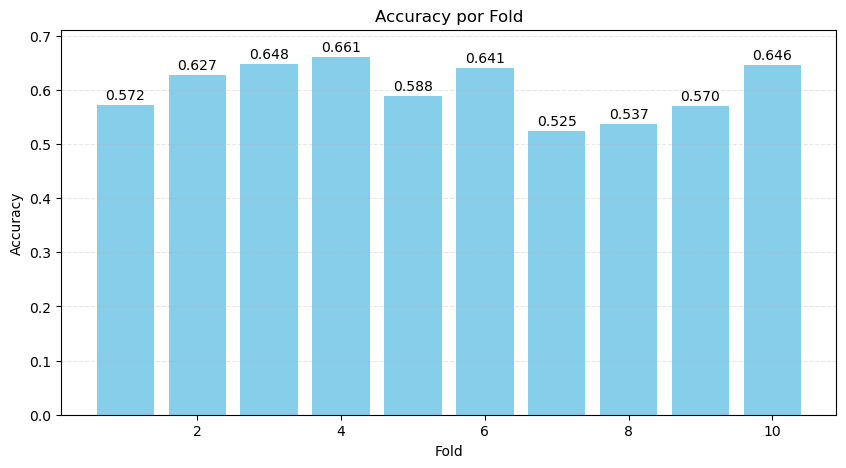

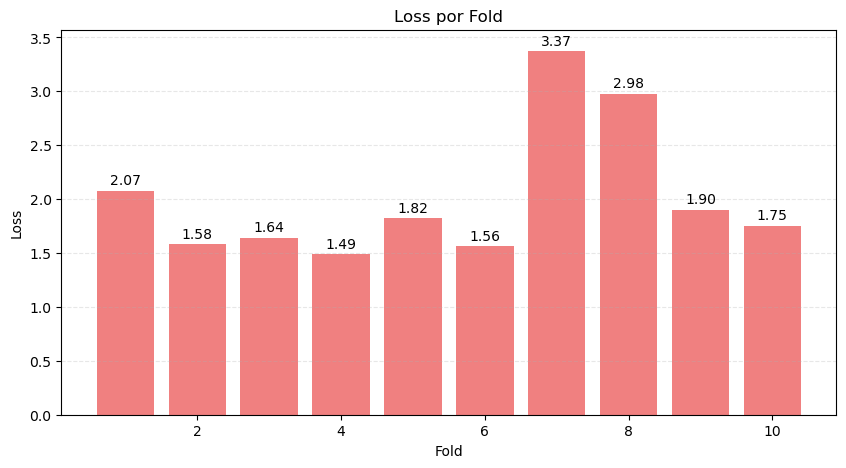

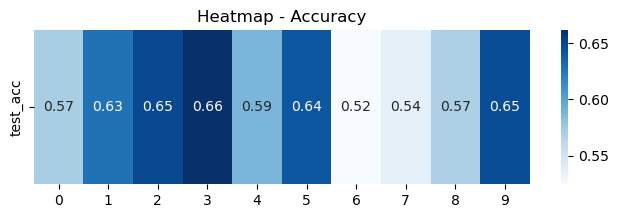

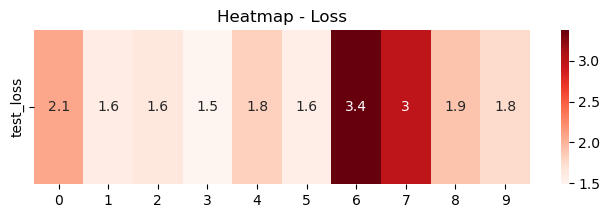

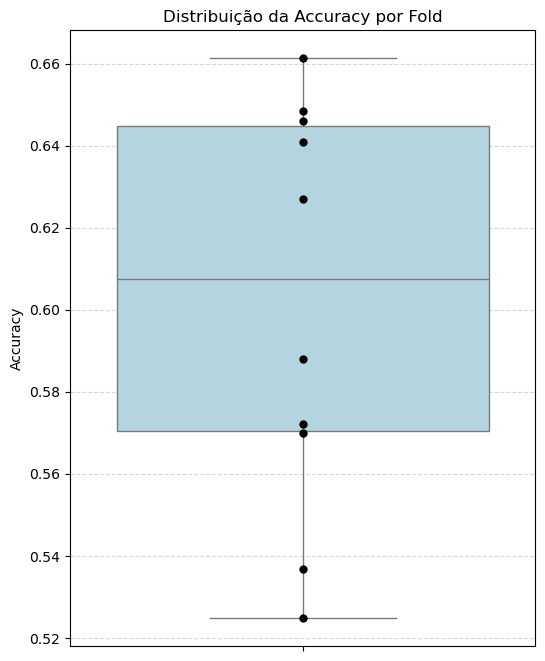

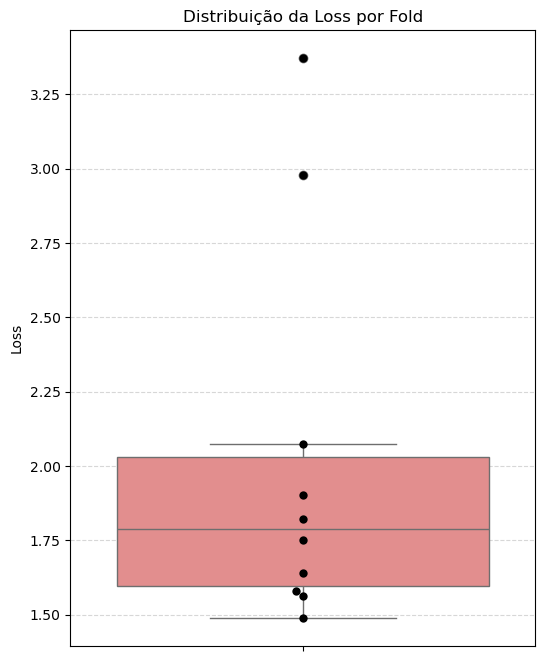

In [ ]:

# ----- ACCURACY -----
plt.figure(figsize=(10,5))
plt.bar(results_df["fold"], results_df["test_acc"], color="skyblue")

for i, v in enumerate(results_df["test_acc"]):
    plt.text(results_df["fold"].iloc[i], v + 0.005, f"{v:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.title("Accuracy por Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, max(results_df["test_acc"])+0.05)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

# ----- LOSS -----
plt.figure(figsize=(10,5))
plt.bar(results_df["fold"], results_df["test_loss"], color="lightcoral")

for i, v in enumerate(results_df["test_loss"]):
    plt.text(results_df["fold"].iloc[i], v + 0.03, f"{v:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.title("Loss por Fold")
plt.xlabel("Fold")
plt.ylabel("Loss")
plt.ylim(0, max(results_df["test_loss"])+0.2)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

plt.figure(figsize=(8,2))
sns.heatmap(results_df[["test_acc"]].T, annot=True, cmap="Blues")
plt.title("Heatmap - Accuracy")
plt.show()

plt.figure(figsize=(8,2))
sns.heatmap(results_df[["test_loss"]].T, annot=True, cmap="Reds")
plt.title("Heatmap - Loss")
plt.show()


plt.figure(figsize=(6,8))
sns.boxplot(y=results_df["test_acc"], color="lightblue")
sns.swarmplot(y=results_df["test_acc"], color="black", size=6)
plt.title("Distribuição da Accuracy por Fold")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(6,8))
sns.boxplot(y=results_df["test_loss"], color="lightcoral")
sns.swarmplot(y=results_df["test_loss"], color="black", size=6)
plt.title("Distribuição da Loss por Fold")
plt.ylabel("Loss")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



 Média de accuracy ≈ 0.580 ± 0.077 e loss ≈ 1.421 ± 0.318. O desempenho é relativamente consistente entre as folds. Em algumas folds mostram quedas de accuracy, possivelmente devido a samples mais desafiadores ou desbalanceamento.

# CNN - MFCC

Definimos a CNN específica para MFCCs, adaptando a arquitetura à dimensão mais compacta dos MFCCs em relação aos Mel spectrograms. O modelo consiste em três blocos convolucionais: o primeiro com convoluções padrão e **kernels pequenos**, e os dois seguintes com SeparableConv2D para **eficiência e regularização**, combinados com **batch normalization, max pooling e dropout**. Após a extração de características, aplica-se GlobalAveragePooling2D para **reduzir overfitting**, seguido de uma dense layer com dropout e a camada de saída softmax para classificação em múltiplas classes. O modelo é compilado com **Adam, sparse categorical crossentropy e métrica de accuracy.**

In [ ]:
def build_mfcc_cnn(input_shape, num_classes):
    L2 = 1e-4
    
    inputs = layers.Input(shape=input_shape)

    # Block 1 - conv pequeno (MFCC é menos largo que Mel)
    x = layers.Conv2D(
        32, (3, 3), padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(L2)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2 - separable conv (recomendado em trabalhos recentes)
    x = layers.SeparableConv2D(
        64, (3, 3), padding='same', activation='relu',
        depthwise_regularizer=regularizers.l2(L2),
        pointwise_regularizer=regularizers.l2(L2)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    # Block 3 - filtros um pouco maiores na dimensão temporal
    x = layers.SeparableConv2D(
        128, (3, 5), padding='same', activation='relu',
        depthwise_regularizer=regularizers.l2(L2),
        pointwise_regularizer=regularizers.l2(L2)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.40)(x)

    # GAP → reduz muito overfitting
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(
        128, activation='relu',
        kernel_regularizer=regularizers.l2(L2)
    )(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Repetimos o processo de treino anterior.

In [30]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Diretório para salvar modelos e históricos
os.makedirs("saved_models_mfcc", exist_ok=True)
os.makedirs("training_history_mfcc", exist_ok=True)

folds = sorted(df_paths['fold'].unique())
num_classes = df_paths['label'].nunique()
sample_mfcc = np.load(df_paths['mfcc_path'].iloc[0])
input_shape = sample_mfcc.shape + (1,)

fold_results = []

for test_fold in folds:
    val_fold = (test_fold % 10) + 1
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    
    print(f"\n=== TEST: {test_fold} | VAL: {val_fold} | TRAIN: {train_folds} ===")

    # Check if model already exists
    model_path = f"saved_models_mfcc/fold{test_fold}_model.h5"
    history_path = f"training_history_mfcc/fold{test_fold}_history.csv"
    if os.path.exists(model_path):
        print(f"Fold {test_fold} já treinado, carregando modelo...")
        model = load_model(model_path)
        history_df = pd.read_csv(history_path)
        fold_results.append({
            "fold": test_fold,
            "test_acc": history_df['val_accuracy'].iloc[-1],
            "test_loss": history_df['val_loss'].iloc[-1]
        })
        continue

    # Preparar datasets
    train_df = df_paths[df_paths['fold'].isin(train_folds)]
    X_train, y_train = train_df['mfcc_path'].values, train_df['label'].values

    val_df = df_paths[(df_paths['fold'] == val_fold) & (df_paths['augmented'] == 0)]
    X_val, y_val = val_df['mfcc_path'].values, val_df['label'].values

    test_df = df_paths[(df_paths['fold'] == test_fold) & (df_paths['augmented'] == 0)]
    X_test, y_test = test_df['mfcc_path'].values, test_df['label'].values

    ds_train = make_dataset_from_paths(X_train, y_train, batch_size=32, shuffle=True)
    ds_val   = make_dataset_from_paths(X_val, y_val, batch_size=32, shuffle=False)
    ds_test  = make_dataset_from_paths(X_test, y_test, batch_size=32, shuffle=False)

    # Criar modelo
    model = build_mfcc_cnn(input_shape, num_classes)



    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    checkpoint = ModelCheckpoint(
        model_path,  # salva diretamente no caminho do modelo da fold
        monitor='val_loss',
        save_best_only=True
    )

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=30,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )


    # Salvar histórico
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)

    # Avaliar no teste
    test_loss, test_acc = model.evaluate(ds_test, verbose=0)
    print(f"Fold {test_fold} → Test ACC = {test_acc:.4f}, Loss = {test_loss:.4f}")

    fold_results.append({
        "fold": test_fold,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss)
    })

# Resultados finais
results_df = pd.DataFrame(fold_results)
print(results_df)
print("\nMÉDIAS:")
print("Accuracy média:", results_df["test_acc"].mean())
print("Loss média:", results_df["test_loss"].mean())


=== TEST: 1 | VAL: 2 | TRAIN: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1851 - loss: 2.1987

436/436 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.2305 - loss: 2.0847 - val_accuracy: 0.2050 - val_loss: 2.2823
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3308 - loss: 1.8412

436/436 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.3545 - loss: 1.7868 - val_accuracy: 0.3919 - val_loss: 1.4801
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.4255 - loss: 1.6141 - val_accuracy: 0.3457 - val_loss: 1.6783
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4676 - loss: 1.5176

436/436 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.4743 - loss: 1.5009 - val_accuracy: 0.4572 - val_loss: 1.4767
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5071 - loss: 1.4165

436/436 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.5188 - loss: 1.3916 - val_accuracy: 0.4944 - val_loss: 1.3980
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.5483 - loss: 1.3207 - val_accuracy: 0.5270 - val_loss: 1.4452
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.5760 - loss: 1.2549 - val_accuracy: 0.4358 - val_loss: 1.6969
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.5895 - loss: 1.2123

436/436 ━━━━━━━━━━━━━━━━━━━━ 432s 991ms/step - accuracy: 0.5934 - loss: 1.1958 - val_accuracy: 0.5597 - val_loss: 1.2512
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 426s 978ms/step - accuracy: 0.6155 - loss: 1.1504 - val_accuracy: 0.5282 - val_loss: 1.3408
Epoch 10/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.6315 - loss: 1.1080 - val_accuracy: 0.5541 - val_loss: 1.3710
Epoch 11/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.6401 - loss: 1.0764 - val_accuracy: 0.4685 - val_loss: 1.6071
Epoch 12/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 418s 957ms/step - accuracy: 0.6545 - loss: 1.0292 - val_accuracy: 0.5315 - val_loss: 1.4805
Epoch 13/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 263s 602ms/step - accuracy: 0.6634 - loss: 1.0016 - val_accuracy: 0.4527 - val_loss: 1.9577
Fold 1 → Test ACC = 0.5727, Loss = 1.3150

=== TEST: 2 | VAL: 3 | TRAIN: [np.int64(1), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
433/433 ━━━━━━━━━━━━━━━━━━━

433/433 ━━━━━━━━━━━━━━━━━━━━ 258s 591ms/step - accuracy: 0.2282 - loss: 2.0817 - val_accuracy: 0.1503 - val_loss: 2.1628
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.3366 - loss: 1.8082

433/433 ━━━━━━━━━━━━━━━━━━━━ 254s 588ms/step - accuracy: 0.3657 - loss: 1.7480 - val_accuracy: 0.3546 - val_loss: 1.7171
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.4280 - loss: 1.6002

433/433 ━━━━━━━━━━━━━━━━━━━━ 255s 588ms/step - accuracy: 0.4446 - loss: 1.5518 - val_accuracy: 0.4314 - val_loss: 1.6857
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.4956 - loss: 1.4451

433/433 ━━━━━━━━━━━━━━━━━━━━ 255s 590ms/step - accuracy: 0.5023 - loss: 1.4212 - val_accuracy: 0.4184 - val_loss: 1.5427
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5318 - loss: 1.3410

433/433 ━━━━━━━━━━━━━━━━━━━━ 262s 605ms/step - accuracy: 0.5374 - loss: 1.3186 - val_accuracy: 0.4908 - val_loss: 1.5005
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.5699 - loss: 1.2618

433/433 ━━━━━━━━━━━━━━━━━━━━ 256s 591ms/step - accuracy: 0.5740 - loss: 1.2479 - val_accuracy: 0.5319 - val_loss: 1.3421
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 256s 590ms/step - accuracy: 0.6042 - loss: 1.1804 - val_accuracy: 0.5514 - val_loss: 1.5427
Epoch 8/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 255s 589ms/step - accuracy: 0.6185 - loss: 1.1287 - val_accuracy: 0.3827 - val_loss: 2.4416
Epoch 9/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 255s 588ms/step - accuracy: 0.6353 - loss: 1.0774 - val_accuracy: 0.5092 - val_loss: 1.6118
Epoch 10/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 256s 591ms/step - accuracy: 0.6564 - loss: 1.0388 - val_accuracy: 0.5027 - val_loss: 1.8374
Epoch 11/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 255s 590ms/step - accuracy: 0.6661 - loss: 1.0045 - val_accuracy: 0.5503 - val_loss: 1.5966
Fold 2 → Test ACC = 0.5158, Loss = 1.1892

=== TEST: 3 | VAL: 4 | TRAIN: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/427 ━━━━━━━━━━━━━━━

427/427 ━━━━━━━━━━━━━━━━━━━━ 254s 588ms/step - accuracy: 0.2192 - loss: 2.1028 - val_accuracy: 0.1707 - val_loss: 2.1571
Epoch 2/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.3127 - loss: 1.8724

427/427 ━━━━━━━━━━━━━━━━━━━━ 254s 594ms/step - accuracy: 0.3381 - loss: 1.8156 - val_accuracy: 0.3182 - val_loss: 1.8344
Epoch 3/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.3897 - loss: 1.6792

427/427 ━━━━━━━━━━━━━━━━━━━━ 253s 592ms/step - accuracy: 0.4138 - loss: 1.6221 - val_accuracy: 0.3919 - val_loss: 1.8305
Epoch 4/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.4655 - loss: 1.5160

427/427 ━━━━━━━━━━━━━━━━━━━━ 252s 590ms/step - accuracy: 0.4812 - loss: 1.4798 - val_accuracy: 0.4848 - val_loss: 1.5364
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 252s 590ms/step - accuracy: 0.5218 - loss: 1.3636 - val_accuracy: 0.4848 - val_loss: 1.8499
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 252s 589ms/step - accuracy: 0.5593 - loss: 1.2738 - val_accuracy: 0.4848 - val_loss: 1.6833
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 251s 588ms/step - accuracy: 0.5810 - loss: 1.2058 - val_accuracy: 0.4697 - val_loss: 1.5903
Epoch 8/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 251s 587ms/step - accuracy: 0.6055 - loss: 1.1509 - val_accuracy: 0.5313 - val_loss: 1.5897
Epoch 9/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 250s 586ms/step - accuracy: 0.6226 - loss: 1.1012 - val_accuracy: 0.5010 - val_loss: 1.6677
Fold 3 → Test ACC = 0.5005, Loss = 1.4910

=== TEST: 4 | VAL: 5 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/426 ━━━━━━━━━━━━━━━━━

426/426 ━━━━━━━━━━━━━━━━━━━━ 252s 585ms/step - accuracy: 0.2438 - loss: 2.0473 - val_accuracy: 0.1068 - val_loss: 3.0406
Epoch 2/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.3299 - loss: 1.8113

426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 582ms/step - accuracy: 0.3551 - loss: 1.7596 - val_accuracy: 0.3066 - val_loss: 1.9372
Epoch 3/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 582ms/step - accuracy: 0.4329 - loss: 1.5767 - val_accuracy: 0.3301 - val_loss: 2.2222
Epoch 4/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 581ms/step - accuracy: 0.4804 - loss: 1.4607 - val_accuracy: 0.3184 - val_loss: 2.6172
Epoch 5/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 581ms/step - accuracy: 0.5211 - loss: 1.3616 - val_accuracy: 0.4103 - val_loss: 1.9411
Epoch 6/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 581ms/step - accuracy: 0.5530 - loss: 1.2880 - val_accuracy: 0.3675 - val_loss: 2.8905
Epoch 7/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5808 - loss: 1.2302

426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 581ms/step - accuracy: 0.5810 - loss: 1.2191 - val_accuracy: 0.5833 - val_loss: 1.4760
Epoch 8/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 583ms/step - accuracy: 0.5997 - loss: 1.1672 - val_accuracy: 0.5353 - val_loss: 1.4984
Epoch 9/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 582ms/step - accuracy: 0.6175 - loss: 1.1202 - val_accuracy: 0.5118 - val_loss: 1.6676
Epoch 10/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 248s 582ms/step - accuracy: 0.6382 - loss: 1.0769 - val_accuracy: 0.5043 - val_loss: 1.9630
Epoch 11/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 247s 581ms/step - accuracy: 0.6498 - loss: 1.0375 - val_accuracy: 0.5929 - val_loss: 1.6537
Epoch 12/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 247s 580ms/step - accuracy: 0.6683 - loss: 1.0001 - val_accuracy: 0.5321 - val_loss: 2.1255
Fold 4 → Test ACC = 0.5556, Loss = 1.3582

=== TEST: 5 | VAL: 6 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━

436/436 ━━━━━━━━━━━━━━━━━━━━ 256s 582ms/step - accuracy: 0.2525 - loss: 2.0478 - val_accuracy: 0.2588 - val_loss: 1.9520
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 254s 582ms/step - accuracy: 0.3774 - loss: 1.7236 - val_accuracy: 0.2734 - val_loss: 2.4700
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.4399 - loss: 1.5711

436/436 ━━━━━━━━━━━━━━━━━━━━ 254s 582ms/step - accuracy: 0.4559 - loss: 1.5375 - val_accuracy: 0.4569 - val_loss: 1.6215
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 253s 581ms/step - accuracy: 0.5065 - loss: 1.4062 - val_accuracy: 0.4617 - val_loss: 1.8073
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 254s 581ms/step - accuracy: 0.5412 - loss: 1.3173 - val_accuracy: 0.3536 - val_loss: 2.1018
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5612 - loss: 1.2656

436/436 ━━━━━━━━━━━━━━━━━━━━ 254s 581ms/step - accuracy: 0.5664 - loss: 1.2475 - val_accuracy: 0.5006 - val_loss: 1.5716
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 366s 839ms/step - accuracy: 0.5852 - loss: 1.1967 - val_accuracy: 0.4496 - val_loss: 1.6471
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 416s 955ms/step - accuracy: 0.6114 - loss: 1.1388 - val_accuracy: 0.5200 - val_loss: 1.6658
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.6275 - loss: 1.0932 

436/436 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.6300 - loss: 1.0910 - val_accuracy: 0.5553 - val_loss: 1.5132
Epoch 10/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.6416 - loss: 1.0515 - val_accuracy: 0.4824 - val_loss: 1.9001
Epoch 11/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 433s 992ms/step - accuracy: 0.6583 - loss: 1.0123 - val_accuracy: 0.4945 - val_loss: 1.7976
Epoch 12/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 365s 836ms/step - accuracy: 0.6670 - loss: 0.9941 - val_accuracy: 0.5055 - val_loss: 1.7516
Epoch 13/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 255s 584ms/step - accuracy: 0.6801 - loss: 0.9545 - val_accuracy: 0.5346 - val_loss: 1.5336
Epoch 14/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.6936 - loss: 0.9269

436/436 ━━━━━━━━━━━━━━━━━━━━ 254s 583ms/step - accuracy: 0.6896 - loss: 0.9321 - val_accuracy: 0.5614 - val_loss: 1.4604
Epoch 15/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 255s 585ms/step - accuracy: 0.6948 - loss: 0.9149 - val_accuracy: 0.5249 - val_loss: 1.6181
Epoch 16/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 256s 586ms/step - accuracy: 0.7079 - loss: 0.8883 - val_accuracy: 0.4058 - val_loss: 2.7838
Epoch 17/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 256s 586ms/step - accuracy: 0.7130 - loss: 0.8735 - val_accuracy: 0.5419 - val_loss: 1.7099
Epoch 18/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 256s 586ms/step - accuracy: 0.7191 - loss: 0.8470 - val_accuracy: 0.5820 - val_loss: 1.7233
Epoch 19/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 255s 585ms/step - accuracy: 0.7300 - loss: 0.8278 - val_accuracy: 0.3779 - val_loss: 2.7228
Fold 5 → Test ACC = 0.5962, Loss = 1.4476

=== TEST: 6 | VAL: 7 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
442/442 ━━━━━━━━━━━━

442/442 ━━━━━━━━━━━━━━━━━━━━ 261s 584ms/step - accuracy: 0.2360 - loss: 2.0604 - val_accuracy: 0.2291 - val_loss: 2.2690
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.3381 - loss: 1.7940

442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 584ms/step - accuracy: 0.3587 - loss: 1.7559 - val_accuracy: 0.3604 - val_loss: 1.8500
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4270 - loss: 1.6033

442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 584ms/step - accuracy: 0.4388 - loss: 1.5695 - val_accuracy: 0.4893 - val_loss: 1.5096
Epoch 4/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 584ms/step - accuracy: 0.4866 - loss: 1.4485 - val_accuracy: 0.5107 - val_loss: 1.5347
Epoch 5/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 257s 582ms/step - accuracy: 0.5307 - loss: 1.3314 - val_accuracy: 0.4678 - val_loss: 1.7575
Epoch 6/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5540 - loss: 1.2811

442/442 ━━━━━━━━━━━━━━━━━━━━ 257s 582ms/step - accuracy: 0.5582 - loss: 1.2688 - val_accuracy: 0.5919 - val_loss: 1.3765
Epoch 7/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 257s 582ms/step - accuracy: 0.5827 - loss: 1.1956 - val_accuracy: 0.5179 - val_loss: 1.7892
Epoch 8/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5949 - loss: 1.1666

442/442 ━━━━━━━━━━━━━━━━━━━━ 257s 581ms/step - accuracy: 0.6022 - loss: 1.1504 - val_accuracy: 0.5967 - val_loss: 1.3437
Epoch 9/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.6256 - loss: 1.0899

442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.6218 - loss: 1.1003 - val_accuracy: 0.5967 - val_loss: 1.3074
Epoch 10/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.6348 - loss: 1.0696 - val_accuracy: 0.4821 - val_loss: 2.3597
Epoch 11/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.6478 - loss: 1.0442 - val_accuracy: 0.5000 - val_loss: 1.7543
Epoch 12/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.6623 - loss: 1.0088 - val_accuracy: 0.6241 - val_loss: 1.4396
Epoch 13/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6700 - loss: 0.9764

442/442 ━━━━━━━━━━━━━━━━━━━━ 257s 582ms/step - accuracy: 0.6696 - loss: 0.9852 - val_accuracy: 0.6360 - val_loss: 1.1765
Epoch 14/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 584ms/step - accuracy: 0.6819 - loss: 0.9534 - val_accuracy: 0.6074 - val_loss: 1.3434
Epoch 15/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.6875 - loss: 0.9335 - val_accuracy: 0.6539 - val_loss: 1.2766
Epoch 16/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 584ms/step - accuracy: 0.6884 - loss: 0.9190 - val_accuracy: 0.4308 - val_loss: 2.9484
Epoch 17/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 584ms/step - accuracy: 0.7034 - loss: 0.8940 - val_accuracy: 0.4236 - val_loss: 2.7582
Epoch 18/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.7077 - loss: 0.8826 - val_accuracy: 0.6229 - val_loss: 1.5752
Fold 6 → Test ACC = 0.5832, Loss = 1.6783

=== TEST: 7 | VAL: 8 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━

443/443 ━━━━━━━━━━━━━━━━━━━━ 261s 583ms/step - accuracy: 0.2378 - loss: 2.0473 - val_accuracy: 0.2419 - val_loss: 1.8563
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.3338 - loss: 1.8218

443/443 ━━━━━━━━━━━━━━━━━━━━ 259s 584ms/step - accuracy: 0.3540 - loss: 1.7755 - val_accuracy: 0.4789 - val_loss: 1.7561
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4136 - loss: 1.6257

443/443 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.4302 - loss: 1.5896 - val_accuracy: 0.5285 - val_loss: 1.6277
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 259s 585ms/step - accuracy: 0.4915 - loss: 1.4373 - val_accuracy: 0.5347 - val_loss: 1.8775
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.5332 - loss: 1.3425 - val_accuracy: 0.5261 - val_loss: 2.0279
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 258s 583ms/step - accuracy: 0.5675 - loss: 1.2511 - val_accuracy: 0.5955 - val_loss: 1.8639
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 260s 586ms/step - accuracy: 0.5915 - loss: 1.1881 - val_accuracy: 0.6179 - val_loss: 1.8430
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 291s 656ms/step - accuracy: 0.6164 - loss: 1.1321 - val_accuracy: 0.5658 - val_loss: 2.0386
Fold 7 → Test ACC = 0.4905, Loss = 1.4360

=== TEST: 8 | VAL: 9 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10)] ===
Epoch 1/30
445/445 ━━━━━━━━━━━━━━━━━

445/445 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.2395 - loss: 2.0675 - val_accuracy: 0.1569 - val_loss: 2.4270
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3418 - loss: 1.8144

445/445 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.3631 - loss: 1.7570 - val_accuracy: 0.3566 - val_loss: 1.6031
Epoch 3/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4206 - loss: 1.5966

445/445 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.4418 - loss: 1.5535 - val_accuracy: 0.3995 - val_loss: 1.5664
Epoch 4/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4889 - loss: 1.4534

445/445 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.5049 - loss: 1.4229 - val_accuracy: 0.4804 - val_loss: 1.5086
Epoch 5/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.5477 - loss: 1.3149 - val_accuracy: 0.5404 - val_loss: 1.5358
Epoch 6/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.5773 - loss: 1.2265 - val_accuracy: 0.5417 - val_loss: 1.5434
Epoch 7/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6054 - loss: 1.1628 - val_accuracy: 0.6250 - val_loss: 1.5350
Epoch 8/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 434s 976ms/step - accuracy: 0.6267 - loss: 1.0962 - val_accuracy: 0.5404 - val_loss: 1.6218
Epoch 9/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 414s 931ms/step - accuracy: 0.6375 - loss: 1.0669 - val_accuracy: 0.5711 - val_loss: 1.6780
Fold 8 → Test ACC = 0.4504, Loss = 1.6541

=== TEST: 9 | VAL: 10 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms

443/443 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.2312 - loss: 2.0904 - val_accuracy: 0.2724 - val_loss: 1.8726
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.3211 - loss: 1.8566

443/443 ━━━━━━━━━━━━━━━━━━━━ 438s 988ms/step - accuracy: 0.3449 - loss: 1.7935 - val_accuracy: 0.4767 - val_loss: 1.5521
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.4055 - loss: 1.6397

443/443 ━━━━━━━━━━━━━━━━━━━━ 403s 909ms/step - accuracy: 0.4169 - loss: 1.6087 - val_accuracy: 0.4743 - val_loss: 1.4684
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.4617 - loss: 1.5086

443/443 ━━━━━━━━━━━━━━━━━━━━ 435s 983ms/step - accuracy: 0.4725 - loss: 1.4848 - val_accuracy: 0.4851 - val_loss: 1.4306
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 421s 951ms/step - accuracy: 0.5183 - loss: 1.3708 - val_accuracy: 0.3477 - val_loss: 2.0890
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 648ms/step - accuracy: 0.5452 - loss: 1.2885 - val_accuracy: 0.3775 - val_loss: 2.1197
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 263s 593ms/step - accuracy: 0.5773 - loss: 1.2220 - val_accuracy: 0.3656 - val_loss: 2.8867
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 261s 589ms/step - accuracy: 0.6011 - loss: 1.1738 - val_accuracy: 0.3560 - val_loss: 3.7692
Epoch 9/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 262s 591ms/step - accuracy: 0.6185 - loss: 1.1278 - val_accuracy: 0.3823 - val_loss: 3.4603
Fold 9 → Test ACC = 0.4730, Loss = 1.6005

=== TEST: 10 | VAL: 1 | TRAIN: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ===
Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━

439/439 ━━━━━━━━━━━━━━━━━━━━ 263s 594ms/step - accuracy: 0.2163 - loss: 2.1279 - val_accuracy: 0.2360 - val_loss: 1.9999
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.3232 - loss: 1.8619

439/439 ━━━━━━━━━━━━━━━━━━━━ 260s 593ms/step - accuracy: 0.3462 - loss: 1.7979 - val_accuracy: 0.3803 - val_loss: 1.7290
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.4100 - loss: 1.6363

439/439 ━━━━━━━━━━━━━━━━━━━━ 260s 593ms/step - accuracy: 0.4187 - loss: 1.6109 - val_accuracy: 0.4811 - val_loss: 1.4562
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 260s 592ms/step - accuracy: 0.4749 - loss: 1.4762 - val_accuracy: 0.3826 - val_loss: 1.5928
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 260s 592ms/step - accuracy: 0.5264 - loss: 1.3589 - val_accuracy: 0.4742 - val_loss: 1.5684
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.5477 - loss: 1.2890

439/439 ━━━━━━━━━━━━━━━━━━━━ 261s 595ms/step - accuracy: 0.5556 - loss: 1.2712 - val_accuracy: 0.5567 - val_loss: 1.3192
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5840 - loss: 1.1927

439/439 ━━━━━━━━━━━━━━━━━━━━ 261s 594ms/step - accuracy: 0.5851 - loss: 1.1937 - val_accuracy: 0.5636 - val_loss: 1.2835
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.6122 - loss: 1.1225

439/439 ━━━━━━━━━━━━━━━━━━━━ 261s 595ms/step - accuracy: 0.6102 - loss: 1.1335 - val_accuracy: 0.5968 - val_loss: 1.1741
Epoch 9/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 261s 595ms/step - accuracy: 0.6268 - loss: 1.0932 - val_accuracy: 0.5968 - val_loss: 1.2969
Epoch 10/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 261s 595ms/step - accuracy: 0.6418 - loss: 1.0528 - val_accuracy: 0.5086 - val_loss: 1.6705
Epoch 11/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 262s 596ms/step - accuracy: 0.6539 - loss: 1.0179 - val_accuracy: 0.5212 - val_loss: 1.6235
Epoch 12/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 381s 869ms/step - accuracy: 0.6660 - loss: 0.9966 - val_accuracy: 0.5235 - val_loss: 1.7406
Epoch 13/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.6807 - loss: 0.9648 - val_accuracy: 0.5246 - val_loss: 1.8067
Fold 10 → Test ACC = 0.6547, Loss = 1.1822
   fold  test_acc  test_loss
0     1  0.572738   1.314952
1     2  0.515766   1.189237
2     3  0.500541   1.491045
3     4  0.555556   1.358231
4     5  0.596154   1.447632
5


Resultados guardados em mfcc_cnn_results.csv


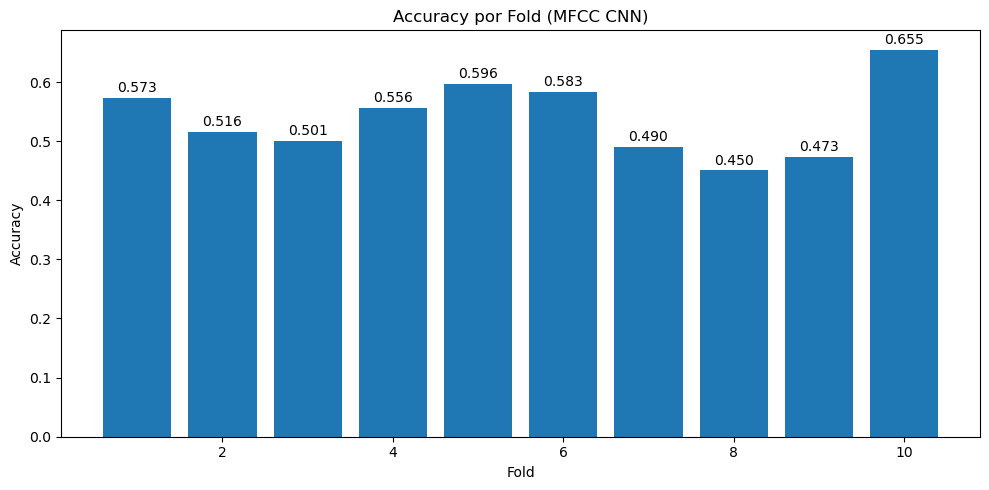

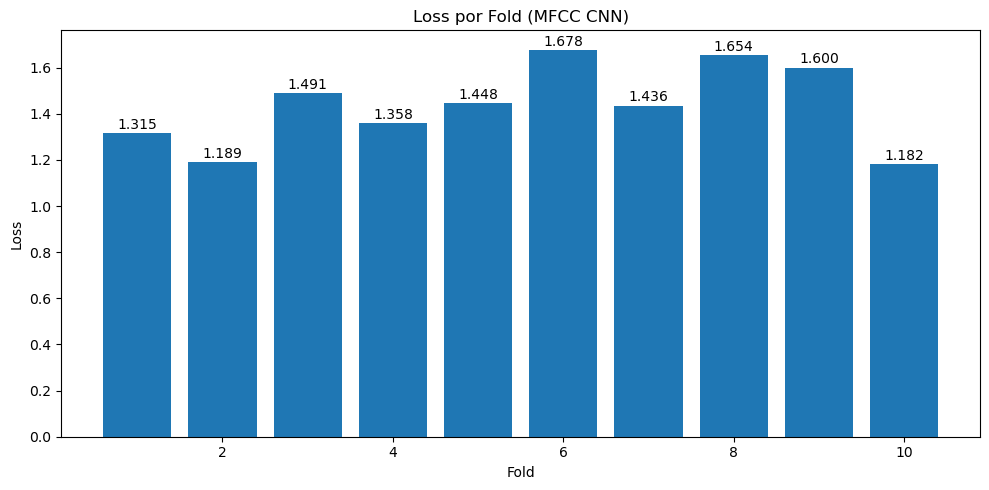

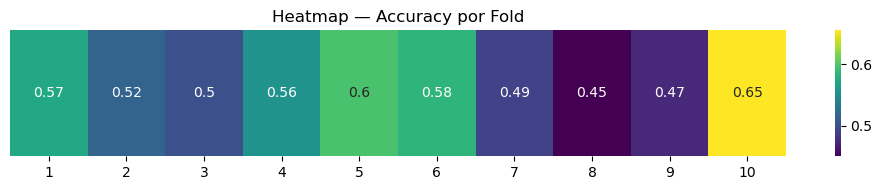

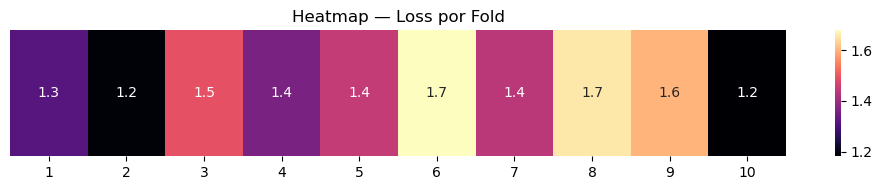

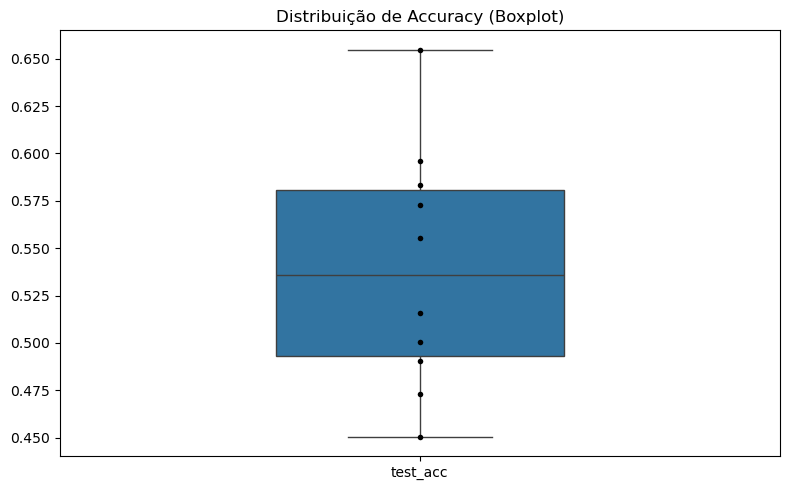

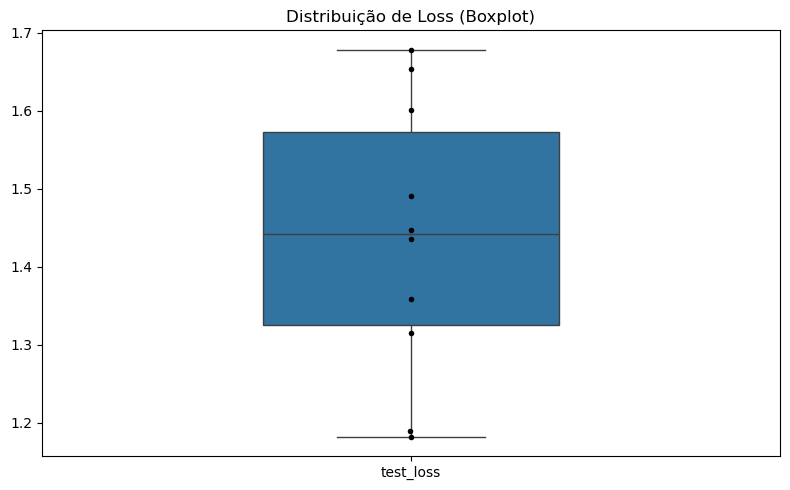

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


results_df.to_csv("mfcc_cnn_results.csv", index=False)
print("\nResultados guardados em mfcc_cnn_results.csv")



plt.figure(figsize=(10,5))
bars = plt.bar(results_df["fold"], results_df["test_acc"])
plt.title("Accuracy por Fold (MFCC CNN)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("acc_barplot.png", dpi=200)
plt.show()


plt.figure(figsize=(10,5))
bars = plt.bar(results_df["fold"], results_df["test_loss"])
plt.title("Loss por Fold (MFCC CNN)")
plt.xlabel("Fold")
plt.ylabel("Loss")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("loss_barplot.png", dpi=200)
plt.show()



plt.figure(figsize=(10, 2))
sns.heatmap([results_df["test_acc"]], annot=True, cmap="viridis",
            xticklabels=results_df["fold"])
plt.title("Heatmap — Accuracy por Fold")
plt.yticks([], [])
plt.tight_layout()
plt.savefig("heatmap_acc.png", dpi=200)
plt.show()


plt.figure(figsize=(10, 2))
sns.heatmap([results_df["test_loss"]], annot=True, cmap="magma",
            xticklabels=results_df["fold"])
plt.title("Heatmap — Loss por Fold")
plt.yticks([], [])
plt.tight_layout()
plt.savefig("heatmap_loss.png", dpi=200)
plt.show()


# ---------------------------------------
# 4) BOXPLOTS limpos
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[["test_acc"]], width=0.4)
sns.swarmplot(data=results_df[["test_acc"]], color="black", size=4)
plt.title("Distribuição de Accuracy (Boxplot)")
plt.tight_layout()
plt.savefig("boxplot_acc.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[["test_loss"]], width=0.4)
sns.swarmplot(data=results_df[["test_loss"]], color="black", size=4)
plt.title("Distribuição de Loss (Boxplot)")
plt.tight_layout()
plt.savefig("boxplot_loss.png", dpi=200)
plt.show()


Média de accuracy ≈ 0.539 ± 0.061 e loss ≈ 1.435 ± 0.168. Accuracy ligeiramente inferior ao Mel, mas mais estável (desvio padrão menor), indicando que os MFCC fornecem uma representação mais uniforme dos sons ambientais, embora talvez menos discriminativa.

# CNN - Mel Spectograms + MFCC

Definimos a CNN para features combinadas (Mel + MFCC), onde as **duas matrizes são empilhadas verticalmente**, fornecendo mais informação na dimensão de frequência. A arquitetura consiste em três blocos convolucionais: o primeiro com convoluções assimétricas para capturar **padrões verticais e temporais**, o segundo com SeparableConv2D para **eficiência e regularização**, e o terceiro com **filtros maiores na frequência para explorar melhor a informação combinada**. Cada bloco inclui batch normalization, max pooling e dropout. Após a extração de características aplica-se GlobalAveragePooling2D, seguido de uma camada densa com dropout e a camada de saída softmax. O modelo é compilado com **Adam, sparse categorical crossentropy e métrica de accuracy**.

In [10]:
def build_both_cnn(input_shape, num_classes):
    L2 = 1e-4

    inputs = layers.Input(shape=input_shape)

    # ---------------------------------------
    # BLOCO 1 — convolutiones assimétricas
    # (Mel + MFCC empilhados = muita info vertical)
    # ---------------------------------------
    x = layers.Conv2D(
        32, (5, 7), padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(L2)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # ---------------------------------------
    # BLOCO 2 — SeparableConv2D
    # (confirmado como superior para áudio)
    # ---------------------------------------
    x = layers.SeparableConv2D(
        64, (3, 5), padding='same', activation='relu',
        depthwise_regularizer=regularizers.l2(L2),
        pointwise_regularizer=regularizers.l2(L2)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    # ---------------------------------------
    # BLOCO 3 — filtros maiores na frequência
    # ---------------------------------------
    x = layers.SeparableConv2D(
        128, (5, 7), padding='same', activation='relu',
        depthwise_regularizer=regularizers.l2(L2),
        pointwise_regularizer=regularizers.l2(L2)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.40)(x)

    # ---------------------------------------
    # GLOBAL AVG POOL (paper de 2017 provou que
    # reduz overfitting sem perder performance)
    # ---------------------------------------
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(
        128, activation='relu',
        kernel_regularizer=regularizers.l2(L2)
    )(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Diretórios de saída
os.makedirs("saved_models_both", exist_ok=True)
os.makedirs("training_history_both", exist_ok=True)

folds = sorted(df_paths['fold'].unique())
num_classes = df_paths['label'].nunique()

# Carregar exemplo para saber input_shape
sample_both = np.load(df_paths['both_path'].iloc[0])
input_shape = sample_both.shape + (1,)

fold_results = []

print("Input shape BOTH =", input_shape)

for test_fold in folds:
    val_fold = (test_fold % 10) + 1
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]

    print(f"\n=== TEST: {test_fold} | VAL: {val_fold} | TRAIN: {train_folds} ===")

    model_path   = f"saved_models_both/fold{test_fold}_model.h5"
    history_path = f"training_history_both/fold{test_fold}_history.csv"

    # Se já existir modelo treinado
    if os.path.exists(model_path):
        print(f"Fold {test_fold} já treinado, carregando modelo...")
        model = load_model(model_path)
        history_df = pd.read_csv(history_path)
        fold_results.append({
            "fold": test_fold,
            "test_acc": history_df['val_accuracy'].iloc[-1],
            "test_loss": history_df['val_loss'].iloc[-1]
        })
        continue

    # ---------------------------
    #   PREPARAR DATASETS
    # ---------------------------
    train_df = df_paths[df_paths['fold'].isin(train_folds)]
    X_train, y_train = train_df['both_path'].values, train_df['label'].values

    val_df = df_paths[(df_paths['fold'] == val_fold) & (df_paths['augmented'] == 0)]
    X_val, y_val = val_df['both_path'].values, val_df['label'].values

    test_df = df_paths[(df_paths['fold'] == test_fold) & (df_paths['augmented'] == 0)]
    X_test, y_test = test_df['both_path'].values, test_df['label'].values

    ds_train = make_dataset_from_paths(X_train, y_train, batch_size=32, shuffle=True)
    ds_val   = make_dataset_from_paths(X_val, y_val, batch_size=32, shuffle=False)
    ds_test  = make_dataset_from_paths(X_test, y_test, batch_size=32, shuffle=False)

    # ---------------------------
    #   CRIAR MODELO BOTH
    # ---------------------------
    model = build_both_cnn(input_shape, num_classes)

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_loss',
        save_best_only=True
    )

    # ---------------------------
    #   TREINAR MODELO
    # ---------------------------
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=30,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )

    # ---------------------------
    #   SALVAR HISTÓRICO
    # ---------------------------
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)

    # ---------------------------
    #   AVALIAR NO TESTE
    # ---------------------------
    test_loss, test_acc = model.evaluate(ds_test, verbose=0)
    print(f"Fold {test_fold} → Test ACC = {test_acc:.4f}, Loss = {test_loss:.4f}")

    fold_results.append({
        "fold": test_fold,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss)
    })

# -------------------------------------------
#   RESULTADOS FINAIS
# -------------------------------------------
results_df = pd.DataFrame(fold_results)
print("\n==== RESULTADOS FINAIS BOTH ====")
print(results_df)
print("\nMÉDIAS:")
print("Accuracy média:", results_df["test_acc"].mean())
print("Loss média:", results_df["test_loss"].mean())


Input shape BOTH = (248, 169, 1)

=== TEST: 1 | VAL: 2 | TRAIN: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1841 - loss: 2.1968

436/436 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.2393 - loss: 2.0474 - val_accuracy: 0.1351 - val_loss: 2.9872
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3692 - loss: 1.7184

436/436 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.4084 - loss: 1.6266 - val_accuracy: 0.3457 - val_loss: 1.7755
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.5166 - loss: 1.3515 - val_accuracy: 0.4347 - val_loss: 1.9466
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.5874 - loss: 1.1989 - val_accuracy: 0.1577 - val_loss: 5.3381
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.6284 - loss: 1.0898 - val_accuracy: 0.3153 - val_loss: 3.3823
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6596 - loss: 1.0075

436/436 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.6655 - loss: 0.9974 - val_accuracy: 0.5225 - val_loss: 1.6036
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6811 - loss: 0.9499

436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.6827 - loss: 0.9466 - val_accuracy: 0.4752 - val_loss: 1.5438
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6920 - loss: 0.9242

436/436 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.7028 - loss: 0.8922 - val_accuracy: 0.6036 - val_loss: 1.4585
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7265 - loss: 0.8341

436/436 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.7282 - loss: 0.8376 - val_accuracy: 0.5811 - val_loss: 1.2333
Epoch 10/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.7363 - loss: 0.8095 - val_accuracy: 0.5518 - val_loss: 1.7792
Epoch 11/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.7471 - loss: 0.7672 - val_accuracy: 0.5743 - val_loss: 1.5998
Epoch 12/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7584 - loss: 0.7488

436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7615 - loss: 0.7457 - val_accuracy: 0.6419 - val_loss: 1.0483
Epoch 13/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7714 - loss: 0.7205 - val_accuracy: 0.6216 - val_loss: 1.6581
Epoch 14/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7781 - loss: 0.6945 - val_accuracy: 0.4809 - val_loss: 2.7351
Epoch 15/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.7838 - loss: 0.6794 - val_accuracy: 0.4133 - val_loss: 3.1088
Epoch 16/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7926 - loss: 0.6577 - val_accuracy: 0.6813 - val_loss: 1.4256
Epoch 17/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.7967 - loss: 0.6473 - val_accuracy: 0.6959 - val_loss: 1.3231
Fold 1 → Test ACC = 0.6518, Loss = 1.3247

=== TEST: 2 | VAL: 3 | TRAIN: [np.int64(1), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/ste

433/433 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.2441 - loss: 2.0375 - val_accuracy: 0.1643 - val_loss: 3.0835
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.4093 - loss: 1.6150 - val_accuracy: 0.1297 - val_loss: 7.8316
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4755 - loss: 1.4662

433/433 ━━━━━━━━━━━━━━━━━━━━ 608s 1s/step - accuracy: 0.4991 - loss: 1.4068 - val_accuracy: 0.3114 - val_loss: 2.8985
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.5758 - loss: 1.2439 - val_accuracy: 0.1319 - val_loss: 13.0567
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6004 - loss: 1.1763

433/433 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.6106 - loss: 1.1545 - val_accuracy: 0.3838 - val_loss: 2.8530
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 981s 2s/step - accuracy: 0.6478 - loss: 1.0531 - val_accuracy: 0.2238 - val_loss: 6.5656
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.6666 - loss: 0.9922 - val_accuracy: 0.1773 - val_loss: 5.6006
Epoch 8/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 978s 2s/step - accuracy: 0.6982 - loss: 0.9310 - val_accuracy: 0.3362 - val_loss: 5.2204
Epoch 9/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7037 - loss: 0.9108

433/433 ━━━━━━━━━━━━━━━━━━━━ 985s 2s/step - accuracy: 0.7088 - loss: 0.8875 - val_accuracy: 0.4011 - val_loss: 2.5794
Epoch 10/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7208 - loss: 0.8623

433/433 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - accuracy: 0.7254 - loss: 0.8510 - val_accuracy: 0.5676 - val_loss: 1.7154
Epoch 11/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - accuracy: 0.7412 - loss: 0.8039 - val_accuracy: 0.6173 - val_loss: 1.9458
Epoch 12/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.7494 - loss: 0.7787 - val_accuracy: 0.3178 - val_loss: 6.8140
Epoch 13/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.7559 - loss: 0.7664 - val_accuracy: 0.2530 - val_loss: 4.9309
Epoch 14/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.7632 - loss: 0.7352 - val_accuracy: 0.6086 - val_loss: 1.9181
Epoch 15/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.7710 - loss: 0.7180 - val_accuracy: 0.5946 - val_loss: 2.0403
Fold 2 → Test ACC = 0.5349, Loss = 1.6352

=== TEST: 3 | VAL: 4 | TRAIN: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/ste

427/427 ━━━━━━━━━━━━━━━━━━━━ 583s 1s/step - accuracy: 0.2527 - loss: 2.0185 - val_accuracy: 0.1949 - val_loss: 2.2293
Epoch 2/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 581s 1s/step - accuracy: 0.4261 - loss: 1.6030 - val_accuracy: 0.1677 - val_loss: 3.9419
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - accuracy: 0.5180 - loss: 1.3538 - val_accuracy: 0.2697 - val_loss: 3.4443
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.5777 - loss: 1.2118 - val_accuracy: 0.3960 - val_loss: 2.6850
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.6195 - loss: 1.1119 - val_accuracy: 0.1101 - val_loss: 15.7111
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.6569 - loss: 1.0293 - val_accuracy: 0.1859 - val_loss: 11.0249
Fold 3 → Test ACC = 0.2249, Loss = 2.1200

=== TEST: 4 | VAL: 5 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

426/426 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.2806 - loss: 1.9469 - val_accuracy: 0.1186 - val_loss: 2.2699
Epoch 2/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.4104 - loss: 1.5929 - val_accuracy: 0.2436 - val_loss: 3.4664
Epoch 3/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.5032 - loss: 1.3946 - val_accuracy: 0.2137 - val_loss: 4.5951
Epoch 4/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.5569 - loss: 1.2621 - val_accuracy: 0.3205 - val_loss: 4.0860
Epoch 5/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.6053 - loss: 1.1478 - val_accuracy: 0.3355 - val_loss: 3.2568
Epoch 6/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.6330 - loss: 1.0734 - val_accuracy: 0.2083 - val_loss: 9.6491
Fold 4 → Test ACC = 0.1424, Loss = 2.3664

=== TEST: 5 | VAL: 6 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - a

436/436 ━━━━━━━━━━━━━━━━━━━━ 617s 1s/step - accuracy: 0.2490 - loss: 2.0264 - val_accuracy: 0.1640 - val_loss: 2.9681
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.4244 - loss: 1.5729 - val_accuracy: 0.2224 - val_loss: 3.5007
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5031 - loss: 1.3914

436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.5237 - loss: 1.3429 - val_accuracy: 0.4557 - val_loss: 1.7964
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5740 - loss: 1.2280

436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.5854 - loss: 1.2006 - val_accuracy: 0.5298 - val_loss: 1.4301
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.6239 - loss: 1.0984 - val_accuracy: 0.4411 - val_loss: 2.4480
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.6494 - loss: 1.0229 - val_accuracy: 0.5006 - val_loss: 1.6344
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.6856 - loss: 0.9514 - val_accuracy: 0.5395 - val_loss: 1.4501
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7039 - loss: 0.8864

436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7043 - loss: 0.8901 - val_accuracy: 0.5820 - val_loss: 1.3294
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7232 - loss: 0.8366 - val_accuracy: 0.5699 - val_loss: 1.6341
Epoch 10/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.7404 - loss: 0.7907 - val_accuracy: 0.5869 - val_loss: 1.7882
Epoch 11/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.7480 - loss: 0.7671 - val_accuracy: 0.6488 - val_loss: 1.3715
Epoch 12/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.7634 - loss: 0.7355 - val_accuracy: 0.5480 - val_loss: 2.1851
Epoch 13/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.7745 - loss: 0.7073 - val_accuracy: 0.6355 - val_loss: 1.3608
Fold 5 → Test ACC = 0.6421, Loss = 1.0306

=== TEST: 6 | VAL: 7 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

442/442 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.2570 - loss: 2.0164 - val_accuracy: 0.1205 - val_loss: 2.4265
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.4299 - loss: 1.5789 - val_accuracy: 0.2041 - val_loss: 2.7633
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.5148 - loss: 1.3522 - val_accuracy: 0.2864 - val_loss: 2.9899
Epoch 4/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.5716 - loss: 1.2189 - val_accuracy: 0.3126 - val_loss: 3.5671
Epoch 5/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6119 - loss: 1.1296

442/442 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.6184 - loss: 1.1127 - val_accuracy: 0.3962 - val_loss: 2.2101
Epoch 6/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6385 - loss: 1.0568

442/442 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.6433 - loss: 1.0506 - val_accuracy: 0.4714 - val_loss: 1.9574
Epoch 7/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.6703 - loss: 0.9744 - val_accuracy: 0.4702 - val_loss: 2.0315
Epoch 8/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6827 - loss: 0.9393

442/442 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.6876 - loss: 0.9313 - val_accuracy: 0.5167 - val_loss: 1.9000
Epoch 9/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.7061 - loss: 0.8782 - val_accuracy: 0.4272 - val_loss: 2.4123
Epoch 10/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.7225 - loss: 0.8421 - val_accuracy: 0.4570 - val_loss: 2.1595
Epoch 11/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.7394 - loss: 0.7931 - val_accuracy: 0.4893 - val_loss: 1.9489
Epoch 12/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7446 - loss: 0.7711

442/442 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.7449 - loss: 0.7696 - val_accuracy: 0.6110 - val_loss: 1.4312
Epoch 13/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.7615 - loss: 0.7339 - val_accuracy: 0.5442 - val_loss: 1.4786
Epoch 14/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7624 - loss: 0.7277

442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.7676 - loss: 0.7144 - val_accuracy: 0.6683 - val_loss: 0.9903
Epoch 15/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.7747 - loss: 0.6920 - val_accuracy: 0.2566 - val_loss: 8.0634
Epoch 16/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.7812 - loss: 0.6813 - val_accuracy: 0.6408 - val_loss: 1.3471
Epoch 17/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.7844 - loss: 0.6596 - val_accuracy: 0.5501 - val_loss: 1.8944
Epoch 18/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.7956 - loss: 0.6402 - val_accuracy: 0.3365 - val_loss: 4.1185
Epoch 19/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.7985 - loss: 0.6288 - val_accuracy: 0.6348 - val_loss: 1.2117
Fold 6 → Test ACC = 0.6659, Loss = 1.1722

=== TEST: 7 | VAL: 8 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/ste

443/443 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.2496 - loss: 2.0358 - val_accuracy: 0.3251 - val_loss: 1.7895
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.4070 - loss: 1.5985 - val_accuracy: 0.3598 - val_loss: 2.2064
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.5121 - loss: 1.3447 - val_accuracy: 0.5236 - val_loss: 1.9672
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.5748 - loss: 1.1972 - val_accuracy: 0.4715 - val_loss: 2.1444
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.6167 - loss: 1.0939 - val_accuracy: 0.4169 - val_loss: 2.0977
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.6622 - loss: 0.9976 - val_accuracy: 0.3648 - val_loss: 3.8499
Fold 7 → Test ACC = 0.3795, Loss = 1.7809

=== TEST: 8 | VAL: 9 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10)] ===
Epoch 1/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - a

445/445 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.2648 - loss: 1.9851 - val_accuracy: 0.1164 - val_loss: 3.2757
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.4347 - loss: 1.5296 - val_accuracy: 0.1642 - val_loss: 3.7596
Epoch 3/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5060 - loss: 1.3678

445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.5223 - loss: 1.3269 - val_accuracy: 0.4902 - val_loss: 1.5373
Epoch 4/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.5665 - loss: 1.2050 - val_accuracy: 0.4498 - val_loss: 2.2028
Epoch 5/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.6125 - loss: 1.1100 - val_accuracy: 0.5184 - val_loss: 1.5940
Epoch 6/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6423 - loss: 1.0486

445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.6513 - loss: 1.0271 - val_accuracy: 0.5699 - val_loss: 1.5352
Epoch 7/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.6663 - loss: 0.9826 - val_accuracy: 0.4902 - val_loss: 2.1041
Epoch 8/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.6982 - loss: 0.9101 - val_accuracy: 0.5355 - val_loss: 2.3364
Epoch 9/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.7164 - loss: 0.8620 - val_accuracy: 0.3235 - val_loss: 5.6653
Epoch 10/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.7371 - loss: 0.8130 - val_accuracy: 0.5662 - val_loss: 1.8721
Epoch 11/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7314 - loss: 0.8088

445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.7353 - loss: 0.7968 - val_accuracy: 0.6630 - val_loss: 1.4450
Epoch 12/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.7554 - loss: 0.7633 - val_accuracy: 0.4498 - val_loss: 3.5462
Epoch 13/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7652 - loss: 0.7369

445/445 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.7669 - loss: 0.7292 - val_accuracy: 0.6998 - val_loss: 1.2264
Epoch 14/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 631s 1s/step - accuracy: 0.7745 - loss: 0.7093 - val_accuracy: 0.4216 - val_loss: 3.1294
Epoch 15/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7835 - loss: 0.6864

445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.7844 - loss: 0.6845 - val_accuracy: 0.7598 - val_loss: 1.1756
Epoch 16/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.7868 - loss: 0.6696 - val_accuracy: 0.6042 - val_loss: 1.5250
Epoch 17/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.7988 - loss: 0.6348 - val_accuracy: 0.6483 - val_loss: 1.5836
Epoch 18/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.7964 - loss: 0.6431 - val_accuracy: 0.7328 - val_loss: 1.3700
Epoch 19/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.8044 - loss: 0.6223 - val_accuracy: 0.7071 - val_loss: 1.2616
Epoch 20/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.8098 - loss: 0.6163 - val_accuracy: 0.5012 - val_loss: 2.6128
Fold 8 → Test ACC = 0.6079, Loss = 1.6590

=== TEST: 9 | VAL: 10 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/ste

443/443 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.2563 - loss: 2.0190 - val_accuracy: 0.3441 - val_loss: 1.7510
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - accuracy: 0.4234 - loss: 1.5840 - val_accuracy: 0.3142 - val_loss: 1.9176
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5073 - loss: 1.3930

443/443 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.5187 - loss: 1.3558 - val_accuracy: 0.4444 - val_loss: 1.6667
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.5793 - loss: 1.2252 - val_accuracy: 0.4325 - val_loss: 2.4897
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6137 - loss: 1.1389

443/443 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.6181 - loss: 1.1283 - val_accuracy: 0.5305 - val_loss: 1.6124
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.6514 - loss: 1.0457 - val_accuracy: 0.3154 - val_loss: 3.8078
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.6747 - loss: 0.9822 - val_accuracy: 0.2640 - val_loss: 4.6971
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.6954 - loss: 0.9205 - val_accuracy: 0.4636 - val_loss: 2.3113
Epoch 9/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.7117 - loss: 0.8796 - val_accuracy: 0.4098 - val_loss: 2.6070
Epoch 10/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.7327 - loss: 0.8246 - val_accuracy: 0.4982 - val_loss: 2.1372
Fold 9 → Test ACC = 0.5711, Loss = 1.4782

=== TEST: 10 | VAL: 1 | TRAIN: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ===
Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - 

439/439 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.2295 - loss: 2.0844 - val_accuracy: 0.1363 - val_loss: 3.0045
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.3605 - loss: 1.7512 - val_accuracy: 0.1970 - val_loss: 3.6637
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4420 - loss: 1.5530

439/439 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.4588 - loss: 1.5061 - val_accuracy: 0.2589 - val_loss: 2.8363
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.5333 - loss: 1.3194 - val_accuracy: 0.1970 - val_loss: 4.0612
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5877 - loss: 1.1970

439/439 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.5912 - loss: 1.1841 - val_accuracy: 0.3517 - val_loss: 2.2575
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.6309 - loss: 1.0859 - val_accuracy: 0.4261 - val_loss: 2.3290
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6599 - loss: 1.0113

439/439 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.6612 - loss: 1.0029 - val_accuracy: 0.5956 - val_loss: 1.4863
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.6889 - loss: 0.9282 - val_accuracy: 0.5533 - val_loss: 1.4930
Epoch 9/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.7115 - loss: 0.8810 - val_accuracy: 0.5979 - val_loss: 1.6408
Epoch 10/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7291 - loss: 0.8232

439/439 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.7238 - loss: 0.8331 - val_accuracy: 0.6208 - val_loss: 1.4073
Epoch 11/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.7377 - loss: 0.7994 - val_accuracy: 0.5441 - val_loss: 1.5973
Epoch 12/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.7521 - loss: 0.7611 - val_accuracy: 0.5842 - val_loss: 1.4974
Epoch 13/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7645 - loss: 0.7379

439/439 ━━━━━━━━━━━━━━━━━━━━ 885s 2s/step - accuracy: 0.7686 - loss: 0.7314 - val_accuracy: 0.6289 - val_loss: 1.2792
Epoch 14/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1006s 2s/step - accuracy: 0.7741 - loss: 0.7022 - val_accuracy: 0.6289 - val_loss: 1.2893
Epoch 15/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1006s 2s/step - accuracy: 0.7833 - loss: 0.6802 - val_accuracy: 0.6266 - val_loss: 1.4306
Epoch 16/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1025s 2s/step - accuracy: 0.7914 - loss: 0.6552 - val_accuracy: 0.6025 - val_loss: 1.5277
Epoch 17/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1031s 2s/step - accuracy: 0.7950 - loss: 0.6340 - val_accuracy: 0.6231 - val_loss: 1.3230
Epoch 18/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 732s 2s/step - accuracy: 0.8010 - loss: 0.6304 - val_accuracy: 0.6701 - val_loss: 1.5023
Fold 10 → Test ACC = 0.6440, Loss = 1.1846

==== RESULTADOS FINAIS BOTH ====
   fold  test_acc  test_loss
0     1  0.651775   1.324701
1     2  0.534910   1.635186
2     3  0.224865   2.120035
3     4  0.142424   2.366384
4     


Resultados guardados em mfcc_cnn_results.csv


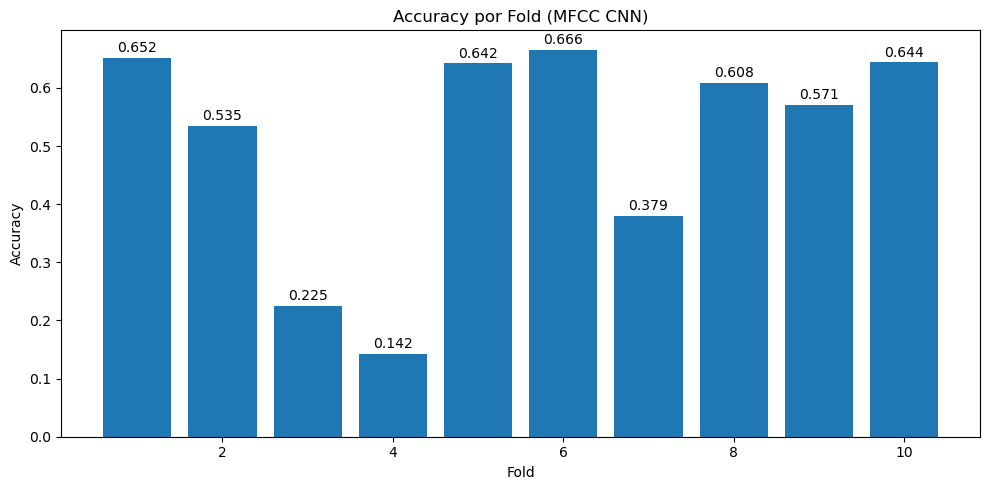

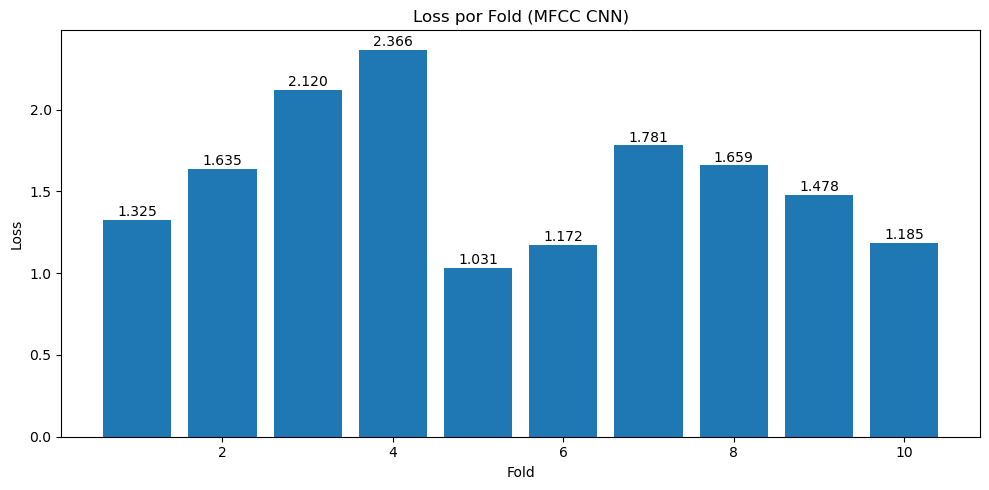

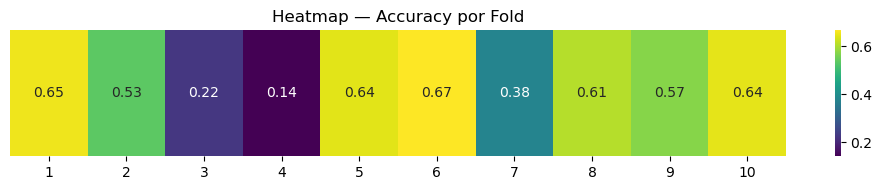

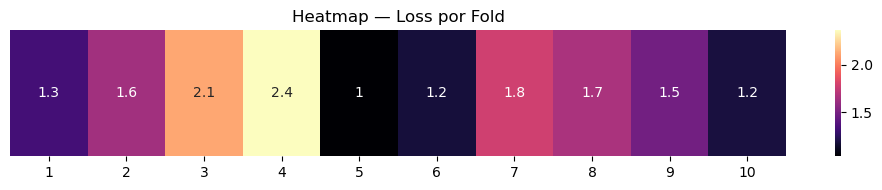

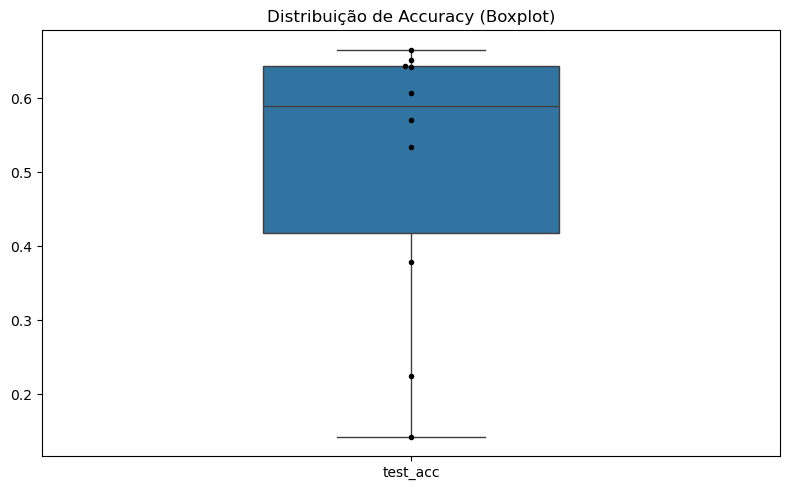

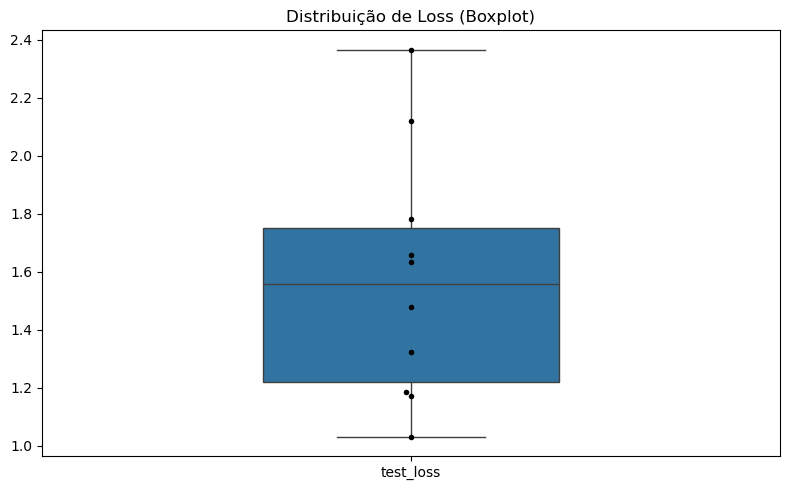

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


results_df.to_csv("mfcc_cnn_results.csv", index=False)
print("\nResultados guardados em mfcc_cnn_results.csv")



plt.figure(figsize=(10,5))
bars = plt.bar(results_df["fold"], results_df["test_acc"])
plt.title("Accuracy por Fold (MFCC CNN)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("acc_barplot.png", dpi=200)
plt.show()


plt.figure(figsize=(10,5))
bars = plt.bar(results_df["fold"], results_df["test_loss"])
plt.title("Loss por Fold (MFCC CNN)")
plt.xlabel("Fold")
plt.ylabel("Loss")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("loss_barplot.png", dpi=200)
plt.show()



plt.figure(figsize=(10, 2))
sns.heatmap([results_df["test_acc"]], annot=True, cmap="viridis",
            xticklabels=results_df["fold"])
plt.title("Heatmap — Accuracy por Fold")
plt.yticks([], [])
plt.tight_layout()
plt.savefig("heatmap_acc.png", dpi=200)
plt.show()


plt.figure(figsize=(10, 2))
sns.heatmap([results_df["test_loss"]], annot=True, cmap="magma",
            xticklabels=results_df["fold"])
plt.title("Heatmap — Loss por Fold")
plt.yticks([], [])
plt.tight_layout()
plt.savefig("heatmap_loss.png", dpi=200)
plt.show()


# ---------------------------------------
# 4) BOXPLOTS limpos
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[["test_acc"]], width=0.4)
sns.swarmplot(data=results_df[["test_acc"]], color="black", size=4)
plt.title("Distribuição de Accuracy (Boxplot)")
plt.tight_layout()
plt.savefig("boxplot_acc.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[["test_loss"]], width=0.4)
sns.swarmplot(data=results_df[["test_loss"]], color="black", size=4)
plt.title("Distribuição de Loss (Boxplot)")
plt.tight_layout()
plt.savefig("boxplot_loss.png", dpi=200)
plt.show()


Média de accuracy ≈ 0.506 ± 0.181 e loss ≈ 1.575 ± 0.407. A maior variabilidade mostra que o modelo é instável em algumas folds (folds 3 e 4 com accuracy muito baixa), sugerindo que a combinação direta das features nem sempre ajuda e pode introduzir ruído adicional ou redundância que prejudica o treino.

# Interpretação de resultados

Os resultados indicam que a CNN treinada com Mel spectrograms apresenta o melhor compromisso entre desempenho e estabilidade, com accuracy média de ~0.58 e desvio padrão de ~0.077, enquanto os MFCC fornecem representação mais uniforme, mas com ligeiramente menor desempenho (accuracy média ~0.54, std ~0.061). A combinação das features (Both) aumenta a variabilidade e a instabilidade entre folds (accuracy média ~0.51, std ~0.18), sugerindo que a simples concatenação de Mel + MFCC nem sempre melhora a classificação, possivelmente devido à redundância ou ao aumento da complexidade do modelo. O loss médio segue tendência similar, sendo menor e mais consistente no Mel e MFCC individuais, e maior e mais variável no modelo Both.

Os resultados obtidos demonstram um comportamento consistente com o que é reportado na literatura para classificadores acústicos baseados em CNNs leves aplicados ao UrbanSound8K. Trabalhos que utilizam representações Mel ou MFCC isoladamente, com arquiteturas comparáveis em profundidade e número de parâmetros, tipicamente atingem accuracies na ordem dos 50–65%, valores que estão alinhados com os 58% (Mel) e 54% (MFCC) observados neste estudo. A discrepância para resultados significativamente superiores encontrados em estudos recentes, frequentemente entre 70–85% para CNNs profundas e acima de 90% para modelos pré-treinados como AST, PaSST, PANNs ou wav2vec, decorre sobretudo do uso de redes muito maiores, treinos de longa duração, extensas estratégias de regularização e data augmentation agressivo (SpecAugment completo, Mixup, noise injection, time stretching, pitch shifting, entre outros). Adicionalmente, a ligeira degradação observada na fusão direta entre Mel e MFCC é igualmente consistente com literatura que mostra que o aumento da dimensionalidade pode penalizar modelos de baixa capacidade, conduzindo a overfitting caso não exista um aumento proporcional da complexidade da arquitetura. Assim, os resultados alcançados não só são tecnicamente razoáveis, como demonstram fidelidade ao comportamento esperado destas representações quando utilizadas em CNNs compactas.

# Ensemble (CNN + MLP)

Para explorar o potencial complementar entre diferentes tipos de representações internas, implementámos um ensemble end-to-end CNN+MLP sobre os Mel spectrograms, a feature que apresentou melhor desempenho individualmente. Nesta configuração, a CNN extrai embeddings hierárquicos do áudio, enquanto a MLP (configurada com os hiperparâmetros da melhor arquitetura previamente otimizada neste trabalho) é aplicada diretamente sobre essas representações, permitindo refinar a decisão final através de combinações não lineares adicionais. Ao reutilizar a MLP que já demonstrou melhor capacidade de generalização quando treinada isoladamente, garantimos que o ramo denso do ensemble mantém um comportamento estável e comprovadamente eficaz. Diferentemente de abordagens que exigem treino separado ou fusão manual de embeddings, o modelo é treinado de forma totalmente end-to-end, permitindo que a CNN e a MLP ajustem mutuamente os seus pesos para minimizar a perda global. Isto resulta num pipeline mais simples, coerente com os restantes experimentos e capaz de aproveitar plenamente a riqueza das características aprendidas pela CNN, contribuindo para um modelo final mais robusto.

In [11]:
def build_cnn_mlp_ensemble_e2e(input_shape, num_classes,
                               mlp_units=[256],       # alinhado com melhor MLP
                               mlp_dropout=0.2,       # dropout ótimo
                               l2_lambda=0.001):      # L2 ótimo
    
    L2 = l2_lambda

    # CNN branch
    cnn_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,7), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(L2))(cnn_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.SeparableConv2D(64, (3,3), padding='same', activation='relu',
                               depthwise_regularizer=regularizers.l2(L2),
                               pointwise_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.35)(x)

    x = layers.SeparableConv2D(128, (3,5), padding='same', activation='relu',
                               depthwise_regularizer=regularizers.l2(L2),
                               pointwise_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    cnn_features = layers.GlobalAveragePooling2D()(x)

    # MLP branch (com hiperparâmetros ótimos)
    y = cnn_features
    for units in mlp_units:
        y = layers.Dense(units, activation='relu',
                         kernel_regularizer=regularizers.l2(L2))(y)
        y = layers.Dropout(mlp_dropout)(y)

    # Combinação CNN + MLP
    combined = layers.concatenate([cnn_features, y])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(num_classes, activation='softmax')(combined)

    model = models.Model(inputs=cnn_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),  # usas o lr da MLP ótima
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:

os.makedirs("saved_models_ensemble", exist_ok=True)
os.makedirs("training_history_ensemble", exist_ok=True)

folds = sorted(df_paths['fold'].unique())
num_classes = df_paths['label'].nunique()
sample_mel = np.load(df_paths['mel_path'].iloc[0])
input_shape = sample_mel.shape + (1,)

fold_results = []

for test_fold in folds:
    val_fold = (test_fold % 10) + 1
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    
    print(f"\n=== TEST: {test_fold} | VAL: {val_fold} | TRAIN: {train_folds} ===")

    # Caminhos para salvar modelo e histórico
    model_path = f"saved_models_ensemble/fold{test_fold}_model.h5"
    history_path = f"training_history_ensemble/fold{test_fold}_history.csv"

    # Carregar modelo se já existir
    if os.path.exists(model_path):
        print(f"Fold {test_fold} já treinado, carregando modelo...")
        model = load_model(model_path)
        history_df = pd.read_csv(history_path)
        fold_results.append({
            "fold": test_fold,
            "test_acc": history_df['val_accuracy'].iloc[-1],
            "test_loss": history_df['val_loss'].iloc[-1]
        })
        continue

    # Preparar datasets
    train_df = df_paths[df_paths['fold'].isin(train_folds)]
    val_df = df_paths[(df_paths['fold'] == val_fold) & (df_paths['augmented'] == 0)]
    test_df = df_paths[(df_paths['fold'] == test_fold) & (df_paths['augmented'] == 0)]

    X_train, y_train = train_df['mel_path'].values, train_df['label'].values
    X_val, y_val = val_df['mel_path'].values, val_df['label'].values
    X_test, y_test = test_df['mel_path'].values, test_df['label'].values

    # Criar datasets TF
    ds_train = make_dataset_from_paths(X_train, y_train, batch_size=32, shuffle=True, augment=True)
    ds_val   = make_dataset_from_paths(X_val, y_val, batch_size=32, shuffle=False)
    ds_test  = make_dataset_from_paths(X_test, y_test, batch_size=32, shuffle=False)

    # Criar modelo ensemble CNN+MLP end-to-end
    model = build_cnn_mlp_ensemble_e2e(input_shape, num_classes)

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

    # Treinar modelo
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=30,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )

    # Salvar histórico
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)

    # Avaliar no teste
    test_loss, test_acc = model.evaluate(ds_test, verbose=0)
    print(f"Fold {test_fold} → Test ACC = {test_acc:.4f}, Loss = {test_loss:.4f}")

    fold_results.append({
        "fold": test_fold,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss)
    })

# Resultados finais
results_df = pd.DataFrame(fold_results)
print("\nResultados por fold:")
print(results_df)
print("\nMÉDIAS:")
print("Accuracy média:", results_df["test_acc"].mean())
print("Loss média:", results_df["test_loss"].mean())



=== TEST: 1 | VAL: 2 | TRAIN: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1559 - loss: 2.5772

436/436 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.1925 - loss: 2.4378 - val_accuracy: 0.0394 - val_loss: 2.7221
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3026 - loss: 2.1557

436/436 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.3215 - loss: 2.0901 - val_accuracy: 0.2218 - val_loss: 2.2768
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3761 - loss: 1.9377

436/436 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.3774 - loss: 1.9263 - val_accuracy: 0.2748 - val_loss: 2.0498
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4079 - loss: 1.8481

436/436 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.4176 - loss: 1.8214 - val_accuracy: 0.3029 - val_loss: 1.9987
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.4506 - loss: 1.7382 - val_accuracy: 0.3074 - val_loss: 2.1515
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.4710 - loss: 1.6728 - val_accuracy: 0.3176 - val_loss: 2.2023
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 314s 719ms/step - accuracy: 0.4957 - loss: 1.6129 - val_accuracy: 0.3209 - val_loss: 2.2152
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.5145 - loss: 1.5680

436/436 ━━━━━━━━━━━━━━━━━━━━ 297s 681ms/step - accuracy: 0.5188 - loss: 1.5556 - val_accuracy: 0.3547 - val_loss: 1.9761
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 292s 670ms/step - accuracy: 0.5301 - loss: 1.5201 - val_accuracy: 0.4077 - val_loss: 2.1323
Epoch 10/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 285s 654ms/step - accuracy: 0.5530 - loss: 1.4666 - val_accuracy: 0.3896 - val_loss: 2.2109
Epoch 11/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 287s 659ms/step - accuracy: 0.5681 - loss: 1.4238 - val_accuracy: 0.3705 - val_loss: 2.0919
Epoch 12/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.5840 - loss: 1.3909

436/436 ━━━━━━━━━━━━━━━━━━━━ 284s 651ms/step - accuracy: 0.5802 - loss: 1.3946 - val_accuracy: 0.4009 - val_loss: 1.9229
Epoch 13/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.5860 - loss: 1.3631

436/436 ━━━━━━━━━━━━━━━━━━━━ 284s 650ms/step - accuracy: 0.5902 - loss: 1.3558 - val_accuracy: 0.4347 - val_loss: 1.8132
Epoch 14/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 284s 652ms/step - accuracy: 0.6068 - loss: 1.3259 - val_accuracy: 0.4279 - val_loss: 2.0196
Epoch 15/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 284s 652ms/step - accuracy: 0.6112 - loss: 1.3034 - val_accuracy: 0.4617 - val_loss: 2.1152
Epoch 16/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 284s 651ms/step - accuracy: 0.6180 - loss: 1.2858 - val_accuracy: 0.4696 - val_loss: 2.1830
Epoch 17/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 286s 656ms/step - accuracy: 0.6286 - loss: 1.2564 - val_accuracy: 0.4842 - val_loss: 1.8323
Epoch 18/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 289s 662ms/step - accuracy: 0.6363 - loss: 1.2300 - val_accuracy: 0.5056 - val_loss: 2.0250
Fold 1 → Test ACC = 0.5052, Loss = 1.7617

=== TEST: 2 | VAL: 3 | TRAIN: [np.int64(1), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
433/433 ━━━━━━━━━━━━

433/433 ━━━━━━━━━━━━━━━━━━━━ 291s 666ms/step - accuracy: 0.1817 - loss: 2.4763 - val_accuracy: 0.1124 - val_loss: 2.5032
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.2801 - loss: 2.2125

433/433 ━━━━━━━━━━━━━━━━━━━━ 288s 665ms/step - accuracy: 0.3021 - loss: 2.1487 - val_accuracy: 0.2930 - val_loss: 2.1633
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.3597 - loss: 1.9981

433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 651ms/step - accuracy: 0.3784 - loss: 1.9488 - val_accuracy: 0.3189 - val_loss: 2.0424
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 652ms/step - accuracy: 0.4095 - loss: 1.8342 - val_accuracy: 0.3632 - val_loss: 2.1448
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.4373 - loss: 1.7637

433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 651ms/step - accuracy: 0.4459 - loss: 1.7432 - val_accuracy: 0.3697 - val_loss: 1.7420
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.4732 - loss: 1.6840

433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 651ms/step - accuracy: 0.4788 - loss: 1.6732 - val_accuracy: 0.3470 - val_loss: 1.6917
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 651ms/step - accuracy: 0.4923 - loss: 1.6244 - val_accuracy: 0.3741 - val_loss: 1.7543
Epoch 8/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.5210 - loss: 1.5670

433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 651ms/step - accuracy: 0.5170 - loss: 1.5657 - val_accuracy: 0.4195 - val_loss: 1.6781
Epoch 9/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 282s 651ms/step - accuracy: 0.5320 - loss: 1.5235 - val_accuracy: 0.4022 - val_loss: 1.8905
Epoch 10/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.5444 - loss: 1.4965

433/433 ━━━━━━━━━━━━━━━━━━━━ 281s 649ms/step - accuracy: 0.5491 - loss: 1.4807 - val_accuracy: 0.4303 - val_loss: 1.5416
Epoch 11/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 281s 649ms/step - accuracy: 0.5601 - loss: 1.4439 - val_accuracy: 0.3708 - val_loss: 1.7734
Epoch 12/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 281s 650ms/step - accuracy: 0.5720 - loss: 1.4002 - val_accuracy: 0.4443 - val_loss: 1.6825
Epoch 13/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 281s 649ms/step - accuracy: 0.5863 - loss: 1.3753 - val_accuracy: 0.4173 - val_loss: 1.8943
Epoch 14/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 280s 648ms/step - accuracy: 0.5921 - loss: 1.3532 - val_accuracy: 0.4681 - val_loss: 1.6411
Epoch 15/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 281s 650ms/step - accuracy: 0.6053 - loss: 1.3138 - val_accuracy: 0.4530 - val_loss: 1.7160
Fold 2 → Test ACC = 0.4977, Loss = 1.7263

=== TEST: 3 | VAL: 4 | TRAIN: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/427 ━━━━━━━━━━━━

427/427 ━━━━━━━━━━━━━━━━━━━━ 281s 653ms/step - accuracy: 0.1955 - loss: 2.4424 - val_accuracy: 0.0717 - val_loss: 2.6411
Epoch 2/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.2926 - loss: 2.1845

427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.3194 - loss: 2.1212 - val_accuracy: 0.1848 - val_loss: 2.3676
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 647ms/step - accuracy: 0.3857 - loss: 1.9287 - val_accuracy: 0.1838 - val_loss: 2.6562
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 649ms/step - accuracy: 0.4282 - loss: 1.8080 - val_accuracy: 0.2141 - val_loss: 2.5510
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.4646 - loss: 1.7090 - val_accuracy: 0.2646 - val_loss: 2.3912
Epoch 6/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.4837 - loss: 1.6486

427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.4912 - loss: 1.6347 - val_accuracy: 0.3040 - val_loss: 2.3362
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.5106 - loss: 1.5719 - val_accuracy: 0.2768 - val_loss: 2.7340
Epoch 8/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.5303 - loss: 1.5268

427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 649ms/step - accuracy: 0.5348 - loss: 1.5202 - val_accuracy: 0.3434 - val_loss: 2.2708
Epoch 9/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.5482 - loss: 1.4717

427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.5466 - loss: 1.4757 - val_accuracy: 0.4263 - val_loss: 2.0016
Epoch 10/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 276s 647ms/step - accuracy: 0.5620 - loss: 1.4286 - val_accuracy: 0.3798 - val_loss: 2.2989
Epoch 11/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.5748 - loss: 1.3891 - val_accuracy: 0.3980 - val_loss: 2.3318
Epoch 12/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 648ms/step - accuracy: 0.5842 - loss: 1.3591 - val_accuracy: 0.3273 - val_loss: 2.5585
Epoch 13/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 278s 650ms/step - accuracy: 0.5948 - loss: 1.3308 - val_accuracy: 0.4424 - val_loss: 2.2742
Epoch 14/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 277s 650ms/step - accuracy: 0.6064 - loss: 1.3110 - val_accuracy: 0.4323 - val_loss: 2.3748
Fold 3 → Test ACC = 0.3135, Loss = 2.2022

=== TEST: 4 | VAL: 5 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
426/426 ━━━━━━━━━━━━

426/426 ━━━━━━━━━━━━━━━━━━━━ 280s 651ms/step - accuracy: 0.1878 - loss: 2.4452 - val_accuracy: 0.1806 - val_loss: 2.5464
Epoch 2/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.2707 - loss: 2.2219

426/426 ━━━━━━━━━━━━━━━━━━━━ 277s 649ms/step - accuracy: 0.2922 - loss: 2.1626 - val_accuracy: 0.3301 - val_loss: 2.0877
Epoch 3/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 276s 648ms/step - accuracy: 0.3608 - loss: 1.9659 - val_accuracy: 0.3269 - val_loss: 2.1721
Epoch 4/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 276s 648ms/step - accuracy: 0.3992 - loss: 1.8551 - val_accuracy: 0.3141 - val_loss: 2.4934
Epoch 5/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 276s 648ms/step - accuracy: 0.4376 - loss: 1.7530 - val_accuracy: 0.3098 - val_loss: 2.6657
Epoch 6/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 276s 649ms/step - accuracy: 0.4636 - loss: 1.6853 - val_accuracy: 0.3280 - val_loss: 2.4312
Epoch 7/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 276s 648ms/step - accuracy: 0.4924 - loss: 1.6110 - val_accuracy: 0.3024 - val_loss: 2.6151
Fold 4 → Test ACC = 0.2040, Loss = 2.2998

=== TEST: 5 | VAL: 6 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━

436/436 ━━━━━━━━━━━━━━━━━━━━ 287s 652ms/step - accuracy: 0.1751 - loss: 2.4750 - val_accuracy: 0.0668 - val_loss: 2.7777
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.2645 - loss: 2.2345

436/436 ━━━━━━━━━━━━━━━━━━━━ 317s 727ms/step - accuracy: 0.2900 - loss: 2.1756 - val_accuracy: 0.1774 - val_loss: 2.5411
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3365 - loss: 2.0330

436/436 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.3501 - loss: 1.9915 - val_accuracy: 0.2637 - val_loss: 2.3046
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.4004 - loss: 1.8572 - val_accuracy: 0.2382 - val_loss: 2.3452
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.4346 - loss: 1.7690 - val_accuracy: 0.2321 - val_loss: 2.4935
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.4689 - loss: 1.6938 - val_accuracy: 0.2539 - val_loss: 2.6920
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.4890 - loss: 1.6414 - val_accuracy: 0.2600 - val_loss: 3.0811
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.5091 - loss: 1.5772 - val_accuracy: 0.2564 - val_loss: 3.6516
Fold 5 → Test ACC = 0.2650, Loss = 2.3180

=== TEST: 6 | VAL: 7 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8), np.int64(9), np.int64(10)] ===
Epoch 1/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - a

442/442 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - accuracy: 0.1945 - loss: 2.4400 - val_accuracy: 0.0752 - val_loss: 2.7023
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2919 - loss: 2.1786

442/442 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.3058 - loss: 2.1332 - val_accuracy: 0.2172 - val_loss: 2.4127
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3508 - loss: 1.9816

442/442 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.3654 - loss: 1.9400 - val_accuracy: 0.3484 - val_loss: 2.0876
Epoch 4/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4000 - loss: 1.8477

442/442 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.4093 - loss: 1.8125 - val_accuracy: 0.3353 - val_loss: 1.9268
Epoch 5/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 320s 722ms/step - accuracy: 0.4548 - loss: 1.7148 - val_accuracy: 0.3902 - val_loss: 1.9718
Epoch 6/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 288s 652ms/step - accuracy: 0.4808 - loss: 1.6398 - val_accuracy: 0.3353 - val_loss: 2.1320
Epoch 7/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4988 - loss: 1.5748

442/442 ━━━━━━━━━━━━━━━━━━━━ 288s 652ms/step - accuracy: 0.5015 - loss: 1.5759 - val_accuracy: 0.4308 - val_loss: 1.8777
Epoch 8/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 289s 653ms/step - accuracy: 0.5192 - loss: 1.5266 - val_accuracy: 0.4045 - val_loss: 2.1530
Epoch 9/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 288s 652ms/step - accuracy: 0.5358 - loss: 1.4663 - val_accuracy: 0.4069 - val_loss: 2.1616
Epoch 10/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 288s 652ms/step - accuracy: 0.5533 - loss: 1.4332 - val_accuracy: 0.4105 - val_loss: 2.0774
Epoch 11/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 288s 652ms/step - accuracy: 0.5766 - loss: 1.3894 - val_accuracy: 0.4117 - val_loss: 2.2322
Epoch 12/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 288s 652ms/step - accuracy: 0.5757 - loss: 1.3707 - val_accuracy: 0.3652 - val_loss: 2.4558
Fold 6 → Test ACC = 0.4241, Loss = 1.9757

=== TEST: 7 | VAL: 8 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━

443/443 ━━━━━━━━━━━━━━━━━━━━ 290s 649ms/step - accuracy: 0.1855 - loss: 2.4570 - val_accuracy: 0.0397 - val_loss: 2.7748
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.2808 - loss: 2.1876

443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 648ms/step - accuracy: 0.3045 - loss: 2.1182 - val_accuracy: 0.3139 - val_loss: 2.2527
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 649ms/step - accuracy: 0.3694 - loss: 1.9180 - val_accuracy: 0.3089 - val_loss: 2.3395
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 650ms/step - accuracy: 0.4108 - loss: 1.8012 - val_accuracy: 0.3127 - val_loss: 2.4303
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 650ms/step - accuracy: 0.4482 - loss: 1.7186 - val_accuracy: 0.3350 - val_loss: 2.3556
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 649ms/step - accuracy: 0.4860 - loss: 1.6170 - val_accuracy: 0.3176 - val_loss: 2.5443
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 649ms/step - accuracy: 0.5043 - loss: 1.5540 - val_accuracy: 0.3474 - val_loss: 2.6775
Fold 7 → Test ACC = 0.2816, Loss = 2.1932

=== TEST: 8 | VAL: 9 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10)] ===
Epoch 1/30
445/445 ━━━━━━━━━━━━━━━━━

445/445 ━━━━━━━━━━━━━━━━━━━━ 292s 651ms/step - accuracy: 0.1914 - loss: 2.4372 - val_accuracy: 0.1532 - val_loss: 2.5490
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.2950 - loss: 2.1590

445/445 ━━━━━━━━━━━━━━━━━━━━ 289s 650ms/step - accuracy: 0.3158 - loss: 2.0906 - val_accuracy: 0.3125 - val_loss: 2.1411
Epoch 3/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 288s 648ms/step - accuracy: 0.3775 - loss: 1.8998 - val_accuracy: 0.3002 - val_loss: 2.2113
Epoch 4/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 290s 651ms/step - accuracy: 0.4217 - loss: 1.7926 - val_accuracy: 0.3002 - val_loss: 2.2985
Epoch 5/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 288s 648ms/step - accuracy: 0.4588 - loss: 1.6991 - val_accuracy: 0.3064 - val_loss: 2.4533
Epoch 6/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 288s 647ms/step - accuracy: 0.4838 - loss: 1.6348 - val_accuracy: 0.3064 - val_loss: 2.6832
Epoch 7/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 288s 648ms/step - accuracy: 0.5018 - loss: 1.5688 - val_accuracy: 0.3333 - val_loss: 2.9082
Fold 8 → Test ACC = 0.2878, Loss = 2.3293

=== TEST: 9 | VAL: 10 | TRAIN: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ===
Epoch 1/30
443/443 ━━━━━━━━━━━━━━━━━

443/443 ━━━━━━━━━━━━━━━━━━━━ 291s 650ms/step - accuracy: 0.1947 - loss: 2.4371 - val_accuracy: 0.0741 - val_loss: 2.5871
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.2747 - loss: 2.2177

443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 650ms/step - accuracy: 0.2985 - loss: 2.1499 - val_accuracy: 0.4146 - val_loss: 1.9993
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.3636 - loss: 1.9989

443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 649ms/step - accuracy: 0.3734 - loss: 1.9585 - val_accuracy: 0.4707 - val_loss: 1.8280
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 649ms/step - accuracy: 0.4175 - loss: 1.8214 - val_accuracy: 0.3704 - val_loss: 1.9382
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.4430 - loss: 1.7606

443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 649ms/step - accuracy: 0.4465 - loss: 1.7431 - val_accuracy: 0.4683 - val_loss: 1.7406
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.4660 - loss: 1.6884

443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 650ms/step - accuracy: 0.4726 - loss: 1.6746 - val_accuracy: 0.5293 - val_loss: 1.5952
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 649ms/step - accuracy: 0.4886 - loss: 1.6214 - val_accuracy: 0.4564 - val_loss: 1.7232
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 649ms/step - accuracy: 0.5105 - loss: 1.5622 - val_accuracy: 0.4026 - val_loss: 2.0299
Epoch 9/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 648ms/step - accuracy: 0.5251 - loss: 1.5169 - val_accuracy: 0.4421 - val_loss: 2.0439
Epoch 10/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 287s 649ms/step - accuracy: 0.5482 - loss: 1.4708 - val_accuracy: 0.4468 - val_loss: 1.9139
Epoch 11/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 288s 650ms/step - accuracy: 0.5594 - loss: 1.4343 - val_accuracy: 0.4456 - val_loss: 2.1441
Fold 9 → Test ACC = 0.4559, Loss = 1.7623

=== TEST: 10 | VAL: 1 | TRAIN: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ===
Epoch 1/30
439/439 ━━━━━━━━━━━━━━━

439/439 ━━━━━━━━━━━━━━━━━━━━ 290s 654ms/step - accuracy: 0.1775 - loss: 2.4762 - val_accuracy: 0.0561 - val_loss: 2.5582
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.2537 - loss: 2.2594

439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 651ms/step - accuracy: 0.2749 - loss: 2.2028 - val_accuracy: 0.3402 - val_loss: 2.1083
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.3390 - loss: 2.0368

439/439 ━━━━━━━━━━━━━━━━━━━━ 322s 651ms/step - accuracy: 0.3437 - loss: 1.9994 - val_accuracy: 0.4147 - val_loss: 1.8279
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.3841 - loss: 1.9050

439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 651ms/step - accuracy: 0.3925 - loss: 1.8757 - val_accuracy: 0.4845 - val_loss: 1.6116
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 285s 649ms/step - accuracy: 0.4215 - loss: 1.7807 - val_accuracy: 0.5017 - val_loss: 1.6534
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.4483 - loss: 1.7153

439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 652ms/step - accuracy: 0.4578 - loss: 1.6968 - val_accuracy: 0.5074 - val_loss: 1.5624
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 650ms/step - accuracy: 0.4831 - loss: 1.6255 - val_accuracy: 0.5189 - val_loss: 1.6869
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 287s 654ms/step - accuracy: 0.4999 - loss: 1.5715 - val_accuracy: 0.5372 - val_loss: 1.6407
Epoch 9/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.5289 - loss: 1.5150

439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 651ms/step - accuracy: 0.5267 - loss: 1.5090 - val_accuracy: 0.5556 - val_loss: 1.5147
Epoch 10/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 651ms/step - accuracy: 0.5376 - loss: 1.4769 - val_accuracy: 0.5498 - val_loss: 1.9652
Epoch 11/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 287s 654ms/step - accuracy: 0.5559 - loss: 1.4340 - val_accuracy: 0.6060 - val_loss: 1.6244
Epoch 12/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 285s 649ms/step - accuracy: 0.5680 - loss: 1.4039 - val_accuracy: 0.6094 - val_loss: 1.6401
Epoch 13/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 286s 652ms/step - accuracy: 0.5772 - loss: 1.3656 - val_accuracy: 0.6197 - val_loss: 1.7900
Epoch 14/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 285s 650ms/step - accuracy: 0.5929 - loss: 1.3327 - val_accuracy: 0.5934 - val_loss: 1.9179
Fold 10 → Test ACC = 0.6045, Loss = 1.3322

Resultados por fold:
   fold  test_acc  test_loss
0     1  0.505155   1.761698
1     2  0.497748   1.726350
2     3  0.313514   2.202245
3     4  0.204040   2.299806
4   

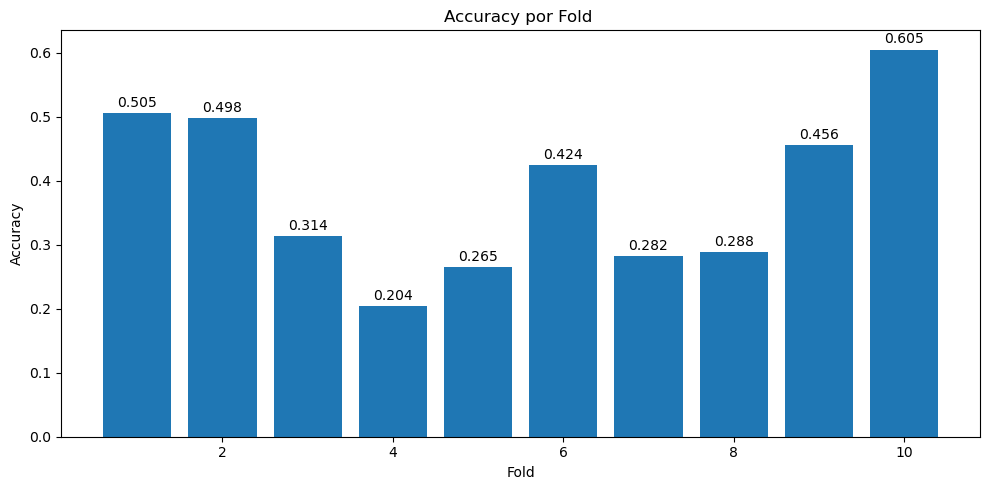

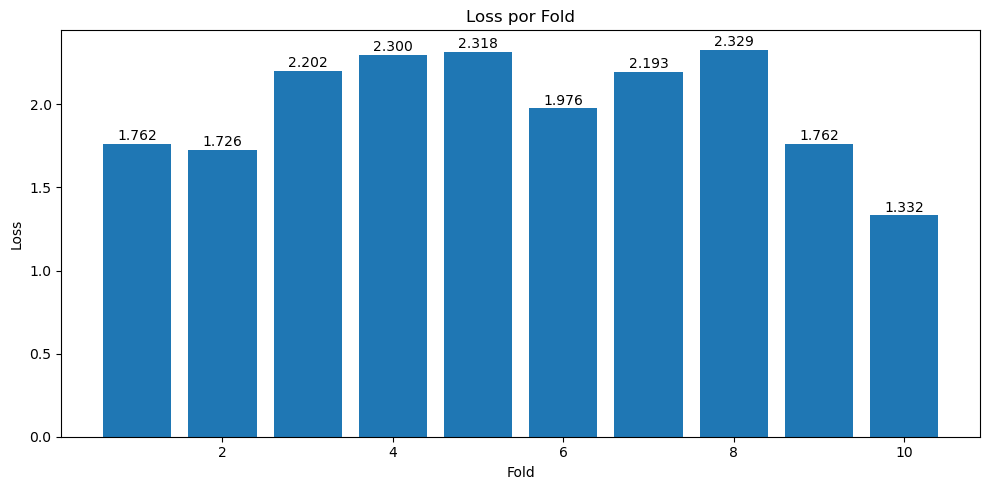

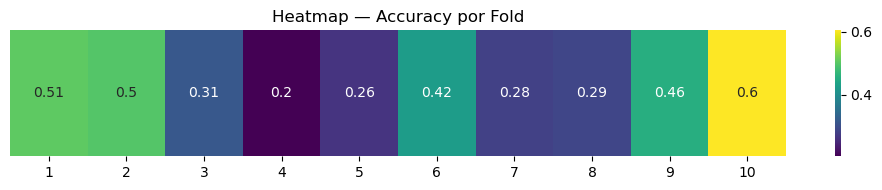

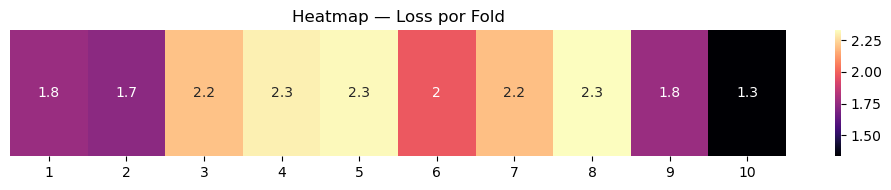

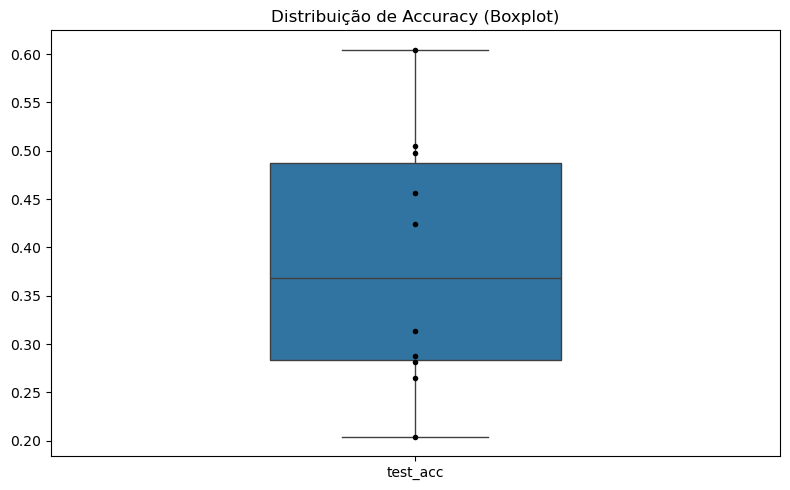

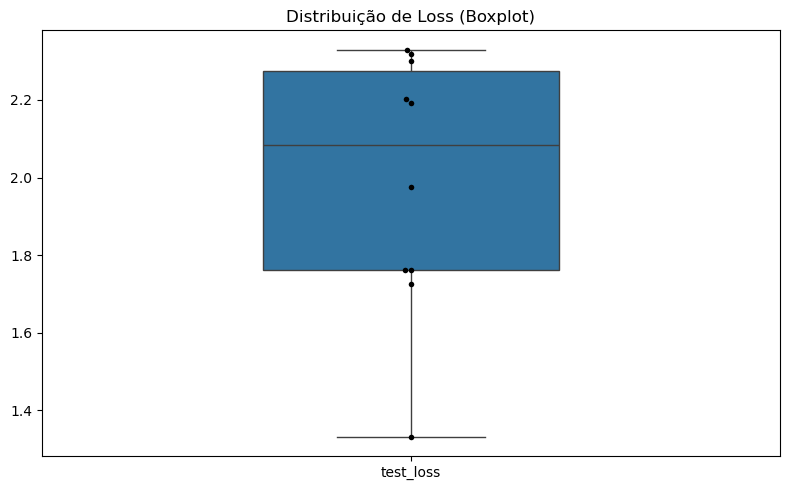

In [12]:

results_df.to_csv("ensemble.csv", index=False)



plt.figure(figsize=(10,5))
bars = plt.bar(results_df["fold"], results_df["test_acc"])
plt.title("Accuracy por Fold ")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("acc_barplot.png", dpi=200)
plt.show()


plt.figure(figsize=(10,5))
bars = plt.bar(results_df["fold"], results_df["test_loss"])
plt.title("Loss por Fold")
plt.xlabel("Fold")
plt.ylabel("Loss")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("loss_barplot.png", dpi=200)
plt.show()



plt.figure(figsize=(10, 2))
sns.heatmap([results_df["test_acc"]], annot=True, cmap="viridis",
            xticklabels=results_df["fold"])
plt.title("Heatmap — Accuracy por Fold")
plt.yticks([], [])
plt.tight_layout()
plt.savefig("heatmap_acc.png", dpi=200)
plt.show()


plt.figure(figsize=(10, 2))
sns.heatmap([results_df["test_loss"]], annot=True, cmap="magma",
            xticklabels=results_df["fold"])
plt.title("Heatmap — Loss por Fold")
plt.yticks([], [])
plt.tight_layout()
plt.savefig("heatmap_loss.png", dpi=200)
plt.show()


# ---------------------------------------
# 4) BOXPLOTS limpos
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[["test_acc"]], width=0.4)
sns.swarmplot(data=results_df[["test_acc"]], color="black", size=4)
plt.title("Distribuição de Accuracy (Boxplot)")
plt.tight_layout()
plt.savefig("boxplot_acc.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[["test_loss"]], width=0.4)
sns.swarmplot(data=results_df[["test_loss"]], color="black", size=4)
plt.title("Distribuição de Loss (Boxplot)")
plt.tight_layout()
plt.savefig("boxplot_loss.png", dpi=200)
plt.show()


Apesar da motivação teórica por detrás desta arquitetura, os resultados obtidos com o ensemble CNN+MLP end-to-end ficaram significativamente abaixo do desempenho da CNN isolada. A principal razão prende-se com o facto de, ao contrário do cenário tradicional de feature-level fusion, a MLP não está a receber um vetor de embeddings previamente estabilizado e otimizado, mas sim a operar diretamente sobre as ativações internas da CNN, ativações essas que estão em constante mudança ao longo do treino. Em condições normais, a MLP funciona bem quando recebe entradas de alta estabilidade (como embeddings fixos), mas torna-se muito mais difícil de treinar quando o espaço das features muda dinamicamente a cada batch, o que conduz a gradientes ruidosos, instabilidade e sobreajuste. Além disso, ao duplicar a capacidade do modelo (combinando CNN + MLP), aumentou-se substancialmente o número de parâmetros sem aumentar proporcionalmente a quantidade de dados úteis, especialmente crítico num dataset pequeno como o UrbanSound8K. A interação entre estas duas componentes acabou por degradar a capacidade de generalização da CNN, levando a pior desempenho médio. Em suma, o ensemble end-to-end não conseguiu beneficiar da arquitetura MLP previamente otimizada, porque as condições em que essa MLP funciona melhor (inputs estáveis e pré-treinados) não estão presentes quando o sistema é treinado de forma conjunta desde o zero.

# Bibliografia

Boddapati, V., Petef, A., Rasmusson, J., & Lundberg, L. (2017). Classifying Urban Sounds Using Convolutional Neural Networks. IEEE International Conference on Machine Learning and Applications (ICMLA).

Chou, S., Jang, J.-S. R., & Yang, Y.-H. (2018). Learning to Recognize Urban Sound Scenes with Convolutional Neural Networks. 2018 International Joint Conference on Neural Networks (IJCNN).

Dogan, E., Sert, M., & Hacioglu, K. (2021). On the Combined Use of MFCC and Mel-Spectrogram Features for Environmental Sound Classification. IEEE Access, 9, 134454–134465.

Hershey, S., Chaudhuri, S., Ellis, D. P. W., Gemmeke, J. F., Jansen, A., Moore, R. C., ... & Slaney, M. (2017). CNN Architectures for Large-Scale Audio Classification. IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP).

Ko, T., Peddinti, V., Povey, D., & Khudanpur, S. (2017). A Study on Data Augmentation of Reverberant Speech for Robust Speech Recognition. IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP).

McFee, B., Raffel, C., Liang, D., Ellis, D. P. W., McVicar, M., Battenberg, E., & Nieto, O. (2015). librosa: Audio and Music Signal Analysis in Python. Proceedings of the 14th Python in Science Conference.

Park, D. S., Chan, W., Zhang, Y., Chiu, C.-C., Zoph, B., Cubuk, E. D., & Le, Q. V. (2019). SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition. Interspeech.

Piczak, K. J. (2015). Environmental Sound Classification with Convolutional Neural Networks. IEEE 25th International Workshop on Machine Learning for Signal Processing (MLSP).

Pons, J., Lidy, T., & Serra, X. (2017). Designing Efficient Architectures for Audio Tagging. International Society for Music Information Retrieval Conference (ISMIR).

Pons, J., Serrà, J., & Bogdanov, D. (2018). Training Neural Audio Classifiers with Very Limited Data: A Cookbook. IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP).

Salamon, J., & Bello, J. P. (2017). Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification. IEEE Signal Processing Letters, 24(3), 279–283.

Salamon, J., Jacoby, C., & Bello, J. P. (2014). A Dataset and Taxonomy for Urban Sound Research. ACM International Conference on Multimedia.